# COCO Project 2024

## ReadMe

Address the following points in a clear and concise manner:
- How the failure scenario has been modeled in the simulation.
  - A failure mode is observed by using the data called *default meal values* in the task description: meals intake of 35, 45 and 45 grams for breakfast, lunch and dinner, respectively. (*Note*: many other failure modes are possible.)
- What parameters are used to demonstrate the failure scenario.
  - The setup is identical as the *current situation* with the only difference being the default meal intakes.
- How the proposed model-based controller is implemented.
  - The tracking MPC is implemented to be DPP (Disciplined Parametrized Programming) compliant, to include input and hard constraints, and reach 100% time-in-target. (detailed explanation below)
- What parameters need to be tuned for the model-based controller.
  - The horizon $K$, the diagonal matrices $Q$ and $S$ that penalize the states, the input penalizer $r$, and the sampling time $T_\text{control}$. (detailed explanation below)
- How you tuned the parameters for the model-based controller and how you would recommend tuning them.
  - By taking the maximal values of PID failure case and use them to normalize $Q = S$ and $r$ with respect to the state of interest. $K$ is chosen long enough to anticipate/predict correctly the delay, and $T_\text{control}$ is set equal to 1 minute as the code is already fast. (detailed explanation below)
  - Instead of using tables of the failure case, one could plot the square deviation from the steady-state and take the values when, for example, the glucose level is precisely at 180 mg/dL.
- How the proposed data-driven controller is implemented.
  - First, a quick investigation of the lag and properties of the Hankel matrix is performed.
  - As our system is non-linear, a regularized DeePC (Data-enabled Predictive Control) is implemented. The regularization are needed to penalize the norm of the decision vector $\textbf{g}$ and the slack variable for the initial conditions $\sigma$.
  - Input constraints and hard and soft constraint are also implemented.
- What parameters need to be tuned for the data-driven controller.
  - The horizon $K$, the output weights $q_1$ and $q_2$ that penalize the outputs $G$ and $I_{sc1}$, the input penalizer $r$, the discretization time $T_\text{discretiz}$, and the control horizon $T_\text{control}$. (detailed explanation below)
- How you tuned the parameters for the data-driven controller and how you would recommend tuning them. 
- If you include an extra slide, a clear explanation of the implementation considerations of your bonus AP controller.


## Project Description

You are a control expert, and you are asked to act as a consultant for InsulinCo, a company that provides [artificial pancreas](https://moodle-app2.let.ethz.ch/pluginfile.php/2009034/mod_resource/content/1/Diabetes_101.pdf) (AP) care to patients with diabetes. Their AP uses an insulin pump to inject insulin in response to glucose measurements and meal predictions. Currently, their AP uses a PID controller.

InsulinCo would like to know if an advanced control method can improve the performance of their AP. You are provided with this Jupyter notebook to develop controller prototypes and provide an answer for them.

InsulinCo is interested in a model-based AP controller, as well as a data-driven AP controller. They want to know if they should pursue a product direction that involves a model that they, perhaps, modify for each patient, or a product direction that relies only upon data from the patient.

To support the model-based approach, InsulinCo has provided a nonlinear model for a specific patient and the linearization of the model at a steady-state operating point. To support the data-driven approach, InsulinCo has provided the time series data for a single patient that they would like you to use for the data-driven controller. 

To test/validate the controllers you develop, InsulinCo has provided you with the [ReplayBG simulator](https://github.com/gcappon/py_replay_bg/tree/master), developed by the company ReplayBGCo, which simulates the nonlinear dynamics of a human glucose regulation mechanism. For the (first) model-based and data-driven controllers that you design, InsulinCo would like you to just use the ReplayBG simulator for testing, not generating additional data. 

InsulinCo is also curious about partnering with ReplayBGCo. To make this decision, they need to know if they could improve their AP controller if they had a full commercial license for the ReplayBG simulator. For bonus credit, use the ReplayBG simulator, or data from the simulator, to either improve upon one of the two AP controllers you proposed in a significant manner, or demonstrate a new controller which requires a simulator or more data.


## Provided to you

This notebook, which contains
- A wrapper of the ReplayBG simulator for you so that you do not need to go through the ReplayBG codebase;
- A nonlinear model of the glucose dynamics derived by their medical specialists;
- A linearization of the nonlinear model for a given patient at a standard operating point;
- The specifications for the PID controller ("handler") that InsulinCo currently uses.

In addition, the JupyterHub contains a time series data set with the input/output data of a “typical” patient.

You may choose to demonstrate the behavior of the controllers using figures and metrics, such as Time-in-range, Time-above-range, and Time-below-range. These are being produced using [Agata](https://github.com/gcappon/py_agata/), a toolbox made to analyze glucose data.


## Code Submission Requirements

Your submission will be verified (your code will be run) using this JupyterHub. You may develop your code using a different machine (e.g. your own, Google Colab, etc.), but it must run in this JupyterHub and should complete in a reasonable (approximately less than 10 minutes) amount of time. If more time is required (e.g. for the bonus), please provide a clear explanation why more computation time is required and a clear demonstration of the output (figures, etc.) that is produced when the code runs to completion.

## Necessary Imports

All the necessary imports should be given in the script below. If you need another import you may add it with a clear description of why you are using it. Large packages such as Deep Reinforcement packages are not allowed since we have not covered that material in this course.

In [1]:
################################### Necessary Imports ##########################################
# all the necessary imports
################################################################################################

# Module for generationg the metrics
from py_agata.py_agata import Agata
from py_agata.time_in_ranges import time_in_target
from py_agata.utils import glucose_time_vectors_to_dataframe

# Function to plot the results
from plot_results import plot_results

# Function to run the simulation
from replay_bg_wrapper import simulate
from py_replay_bg.model.t1d_model import T1DModel
from py_replay_bg.py_replay_bg import ReplayBG

# Python imports
import pandas as pd
import os
import numpy as np
from random import randint

# Convex optimization problems with Python
from cvxpy.reductions.solvers.defines import QP_SOLVERS
import cvxpy as cp

# Added to plot and display matrix and vectors
from IPython.display import display
import matplotlib.pyplot as plt

## ReplayBG Model

The ReplayBG simulation is defined by the following differential equations:

<div>
    <img src="model.png" width="1000"/>
</div>


### Outputs

The output is the blood glucose. This hypoglycemia limit of 70 (mg/dl) is a hard lower-limit for blood glucose, as dropping below 70 (mg/dl) is a significant health risk. In addition, if possible, blood glucose should be kept below 180 (mg/dl). This hyperglycemia limit is a "soft constraint" rather than a hard constraint - minor infractions are not critical, but it is better to keep blood glucose below 180 (mg/dl) if possible.


### Inputs

Two inputs affect glucose levels:
- $i(t)$: Exogenous/Basal insulin injections (units "U" of insulin). Controlled.
- $m(t)$: Carbohydrate intake/"meals" (g). Not controlled.

Thus, the input is two-dimensional: $\textbf{u} = \begin{bmatrix}i(t) & m(t) \end{bmatrix}^T$. In the literature, $i(t)$ is also refered to as $I(t)$ or *basal insulin*, and $m(t)$ is also refered to as $CHO(t)$.

While we cannot control the meals, we assume that the meal injections are known by the controller (hence, being an "input" rather than a disturbance). 

The meals are determined by the `data_cho.csv` file and are parsed by the ```get_discretized_meals()``` function, which multiplies the values in the data.csv file by 5 because each meal takes 5 minuntes. 

The controller determines the exogenous insulin injection in control time intervals that are specified by the user (e.g. 5 or 10 minutes). The control time interval is a design decision for you to make. 

### Insulin Limits

The maximum exogenous/basal insulin injection $i(t)$ is 0.04, and the minimum is 0.

### Default Meal Values

The default meal values, which InsulinCo is interested in with the initial (model-based and data-driven) control designs, are 35 g for breakfast and 45 g for lunch and dinner.

For the bonus, you might consider larger/different meals.

### State Variables
The state of the system is defined by the following variables:
- $G_p(t)$: Plasma glucose concentration (mg/dl);
- $X(t)$: Insulin action on glucose disposal and production ($\text{min}^{-1}$);
- $Q_{sto1}(t)$: Amount of insulin in the stomach in solid state (mg/kg);
- $Q_{sto2}(t)$: Amount of insulin in the stomach in liquid state (mg/kg);
- $Q_{gut}(t)$: Glucose concentration in the intestine (mg/kg);
- $I_{sc1}(t)$: Insulin in a non-monomeric state (mU/kg);
- $I_{sc2}(t)$: Insulin in a monomeric state (mU/kg);
- $I_p(t)$: Plasma insulin concentration (mU/I);
- $G(t)$: interstitial glucose concentration (mg/dl);

For following the ReplayBG practices, the state equation is set as:
$$x(t) = \begin{bmatrix} G_p(t) & X(t) & Q_{sto1}(t) & Q_{sto2}(t) & Q_{gut}(t) & I_{sc1}(t) & I_{sc2}(t)& I_p(t) & G(t) \end{bmatrix}^T$$

### System Equations
The Non-Linear Differential Equations which describe the behavior of the system are the following:

$\dot{G_p}(t) = -[SG + \rho(G)X(t)] \cdot G_p(t) + SG \cdot G_{b} + R_{\alpha}(t)/V_G$

$\dot{X}(t) = -p_2 \cdot [X(t) - SI \cdot (I_p(t) - I_pb)]$

$\dot{Q}_{sto1}(t) = -k_{empt} \cdot Q_{sto1}(t) + m(t)$

$\dot{Q}_{sto2}(t) = k_{empt} \cdot Q_{sto1}(t) - k_{empt} \cdot Q_{sto2}(t)$

$\dot{Q}_{gut}(t) = k_{empt} \cdot Q_{sto2}(t) - k_{abs} \cdot Q_{gut}(t)$

$\dot{I}_{sc1}(t) = -k_{d}\cdot I_{sc1}(t) + i(t-\beta / V_{I})$

$\dot{I}_{sc2}(t) = k_{d}\cdot I_{sc1}(t) - k_{\alpha2} \cdot I_{sc2}(t)$

$\dot{I}_{p}(t) = k_{\alpha2} \cdot I_{sc2}(t) - k_{e} \cdot I_{p}(t)$

$\dot{G}(t) = -\frac{1}{\alpha}(G(t) - G_p(t))$

where, $k_{d}, k_{\alpha2}, k_e, \beta, k_{empt}, k_{abs}, \alpha, p_2$ are parameters describing the rate of diffusion and absorption of insulin, $V_{I}$ is the volume of insulin distribution, $R_{\alpha}(t)$ is the rate of glucose appearance in plasma, $SG$ is the glucose effectiveness, $G_b$ is the basal glucose concentration in the plasma, $V_G$ is the volume of glucose distribution, $I_{pb}$ is the basal insulin concentration in the plasma, $SI$ is the insulin sensitivity, $\rho(G)$ is a function to better represent glucose dynamics in the hypoglycemic range. 

The $I$ variables and the associated equations describe the absorption dynamics of exogenous insulin infusion to the plasma, the $Q$ variables describe the glucose absorption due to meals, and the last 3 equations describe the glucose-insulin kinetics subsystem.  

### Linearized Equations

We linearized the nonlinear dynamics above around the steady state
$$x_{ss} = \begin{bmatrix}120.0 & 0.0016 & 0.0 & 0.0 & 0.0 & 1.5081 &10.2735 & 0.2827 & 120.0\end{bmatrix}$$
using a discretization step of 1 minute.
The linearized dynamics model has the form

$$\textbf{x}_{k+1} = A \textbf{x}_{k} + B\textbf{u}_{k} + h.$$
 
- $A \in \mathbb{R}^{9\times9}$ is the dynamics matrix,
- $B \in \mathbb{R}^{9\times2}$ is the input matrix, and
- $h \in \mathbb{R}^{9\times1}$ is the offset constant produced by the linearization.

<font color='red'>NOTE</font>: There are three different time intervals: the time-discretization of the simulation (1 minute), the meal time interval (5 minutes), and the controller actuation time interval (up to you).


## ReplayBG Specifics

```simulate()``` runs a sytem simulation. It takes the following inputs:
- basal_handler: the function/controller that returns the  basal insulin injection value
- basal_handler_params: dict() with parameters defined by the control designer that can be accessed during simulation by the handler
- data_given: a pandas dataframe that describes the meal intake. The example below shows how to create the dataframe by reading the meal csv file (the control designer may change the csv file or define multiple csv files/dataframes as needed)
- meal_input_modulation_factor: constant that modules the impact of a meal (the default value should be used)

```T1DModel```: The T1DModel class is a part of ReplayBG's simulator and describes the glucose dynamics. It takes the following inputs:
- data: pandas dataframe which contains the preliminary meal data ("data" is not very relevant as it is overwritten with data_given when ```simulate()``` is called)
- bw: the body weight of the patient (the default value should be used)
- yts: The continuous glucose measurement (cgm) sample time (the default value should be used)
- glucose_model: the model equation to be used as measured glucose ('IG' should be used)
- is_single_meal: a flag indicating if the model will be used as single meal or multi meal (the default value (False) should be used)
- exercise: a boolean indicating if the model includes exercise (the default value (False) should be used)

The initial control design should not need most of the inputs, as InsulinCo is primarily interested in performance on the basic/default case. For the bonus, you could consider changing some of the inputs. Keep in mind, InsulinCo is primarily interested in new control methods rather than exhaustive studies, so any parameter changes should be used/changed to demonstrate the value of a given controller, not for the sake of an exhaustive study.

Below are some additional functions from InsulinCo intended to make the ReplayBG simulator easier to use.

`get_linearization()`: InsulinCO has provided this function to you to help design your controllers. It linearizes the dynamics around a given operating point but does *not* take into account the basal insulin injection delay. This means that for a given time index $t$ and a delay $\tau$, the basal insulin injection value returned by the controller will only be seen by the system at the time step $t+\tau$. This also means that for the same $t$, the control actions at the time steps between $t$ and $t+\tau-1$ are already defined and cannot be changed. 

<font color='red'>NOTE</font>: The ReplayBG simulator has a delay that is not included in the linearization. This delay must be factored in separately from the linearizaed dynamics described by the matrix $A$.

`get_discretized_meals()`: InsulinCo has provided this function to you to help interface between the ReplayBG simulator and the csv (that you may edit) that defines the meals. `get_discretized_meals()` is helpful because of how ReplayBG processes the meal data. Specifically, ReplayBG does some operations on the values written in the csv file to get the value of $m(t)$. Thus, to access this internal variable of ReplayBG, InsulinCo created this function which returns a vector with the all the $m[k]$ in a certain interval of time and according to a discretization time step. 

In [2]:
######################## additional functions for ReplayBG's T1DModel class  ###################
# Here define some additional functions for the T1DModel class that you may find useful.
################################################################################################

def get_discretized_meals(self, initial_time_step, duration, T):
    """
    Parameters
    ----------
    initial_time_step : initial time step of the intended interval that we want to get the meals from
    duration : duration of the interval that we want to get the meals from
    T : discretization step
    
    Returns
    -------
    meal : a vector with all the meals in the time interval given
    """
    meal = np.zeros((duration//T, ))
    for k in range((duration)):
        meal[k//T] += self.meal_ALL_delayed[initial_time_step+k]
    return meal
    
def get_linearization(self, T, x):
    """
    Provides the linearization parameters, given the discretization interval and the state at which the linearization is done.
    
    Parameters
    ----------
    T : discretization step
    x : linearization point
    
    Returns
    -------
    A, B, h : discretized linear state equations
    """
    x0 = x[0]
    x1 = x[1]

    mp = self.model_parameters

    k1_T = 1 / (1 + T*mp.kgri)
    k2_T = T*mp.kgri / (1 + T*mp.kempt)
    k3_T = 1 / (1 + T*mp.kempt)
    kb_T = 1 / (1 + T*mp.kabs_avg)
    ki1_T = 1 / (1 + T*mp.kd)
    ki2_T = 1 / (1 + T*mp.ka2)
    kie_T = 1 / (1 + T*mp.ke)

    x1_c_T = mp.p2 * mp.SI / mp.VI * T/(1+mp.p2*T)
    x4_c_T = T*mp.kempt * kb_T
    x6_c_T = T*mp.kd * ki2_T
    x7_c_T = T*mp.ka2 * kie_T

    df_dx0 = -mp.SG - x1 * (1 + mp.r1)
    df_dx1 = -x0 * (1 + mp.r1)
    df_dx4 = (mp.f * mp.kabs_avg) / mp.VG
    dx0_dt = -mp.SG*x0 -x0*x1*(1 + mp.r1) + mp.SG*mp.Gb
    div = (1-T*df_dx0)

    #                      x0               x1            x2      x3         x4        x5           x6            x7         x8
    self.Alinear[:] =  [ [1/div         , T*df_dx1/div , 0   , 0     , T*df_dx4/div, 0     , 0             , 0           , 0             ],
                         [0             , 1/(1+mp.p2*T), 0   , 0     , 0           , 0     , x1_c_T*x7_c_T , x1_c_T*kie_T, 0             ],
                         [0             , 0            , k1_T, 0     , 0           , 0     , 0             , 0           , 0             ],
                         [0             , 0            , k2_T, k3_T  , 0           , 0     , 0             , 0           , 0             ],
                         [0             , 0            , 0   , x4_c_T, kb_T        , 0     , 0             , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , ki1_T , 0             , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , x6_c_T, ki2_T         , 0           , 0             ],
                         [0             , 0            , 0   , 0     , 0           , 0     , x7_c_T        , kie_T       , 0             ], 
                         [T/(T+mp.alpha), 0            , 0   , 0     , 0           , 0     , 0             , 0           , mp.alpha/(T+mp.alpha)]]

    self.Blinear[:] = [0, 0, 0, 0, 0, T/(1+T*mp.kd)*mp.to_mgkg, 0, 0, 0]
    self.Mlinear[:] = [0, 0, k1_T, 0, 0, 0, 0, 0, 0]
    self.hlinear[:] = [ T*(dx0_dt - x0*df_dx0 - x1*df_dx1)/div, 0, 0, 0, 0, 0, 0, 0, 0]

    return self.Alinear, np.vstack((self.Blinear, self.Mlinear)).T, self.hlinear

In [3]:
##################################### Linearization example  ###################################
# A demonstration of T1DModel and get_linearization()
################################################################################################

# State Definition
x0 = np.array([120.0, 0.0016, 0.0, 0.0, 0.0, 1.5081, 10.2735, 0.2827, 120.0])
tau = 8 # min of delay for controler to act

#Some parameters of the patient (everything is set in the simulation for your controllers. These are only examples)
bw = 62.0
data = pd.read_csv(
        os.path.join(os.path.abspath(''), 'data', 'data_cho.csv'))
data.t = pd.to_datetime(data['t'], format='mixed')

t1d_model = T1DModel(data=data,
                     bw=bw,
                     yts=5,
                     glucose_model='IG',
                     is_single_meal=False,
                     exercise=False)

# To design the controller two function will be needed:
# - t1d_model.get_linearization
# - t1d_model.get_discretized_meals 

# Example of running the function for getting the system equations
A_, B_, h_ = t1d_model.get_linearization(1, x0)
print("A:\n", A_.round(3), "\n"*2, "B:\n", B_.round(3), "\n"*2, "h:\n", h_.round(3))
i = 0.0
m = 0.0

A:
 [[ 9.72000e-01 -2.84656e+02  0.00000e+00  0.00000e+00  7.00000e-03
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  9.88000e-01  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  8.47000e-01  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  1.53000e-01  8.47000e-01  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  1.78000e-01  9.88000e-01
   0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   9.75000e-01  0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   2.60000e-02  9.86000e-01  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  1.20000e-02  8.87000e-01  0.00000e+00]
 [ 1.25000e-01  0.00

## Simulator Demonstration with a simple logic-based controller

To develop intuition, InsullinCo has provided a scenario with a basic basal insulin controller: if glucose is below 90 no insulin is delivered; if glucose is above 90, a default rate is delivered. 

The file `(data_cho.csv)` describes the meal consumption for the patient over the course of a day.

In [4]:
##################################### Example of loading and modifying meal data  ###################################

# # Load the CSV File
# df = pd.read_csv('data/data_cho.csv')

# # Print the first lines of the File (otherwise you can also easily check it by manually opening the file in Jupyter lab)
# print("Patient Datasheet", "\n", df.head())

# # Modify the DataFrame
# # Suppose you want to change the value in row 1, column 'ColumnName' to 'NewValue'
# df.at[108, 'cho'] = 9

# # Save the Modified DataFrame
# df.to_csv('your_file.csv', index=False)

In [42]:
##################################### Modify csv data TESTS and DEFAULT ###################################
# all data are cut and saved
################################################################################################

# Load the CSV File
df_cho = pd.read_csv('data/data_cho.csv')

df_default = df_cho.copy()

# Default meal values
discretization_time_meal = 5 #min
m_B = 35 #g for breakfast
m_L = 45 #g for lunch
m_D = 45 #g for dinner

# Modify the DataFrame
df_default.loc[df_default['cho_label'] == 'B', 'cho'] = m_B / discretization_time_meal
df_default.loc[df_default['cho_label'] == 'L', 'cho'] = m_L / discretization_time_meal
df_default.loc[df_default['cho_label'] == 'D', 'cho'] = m_D / discretization_time_meal

# Save the Modified DataFrame
df_default.to_csv(os.path.join(os.path.abspath(''), 'data', 'default_data.csv'))

# Maximum meal test
df_max = df_default.copy()
m_max = 140 #g for maximum meal

df_max.loc[df_max['cho_label'] == 'L', 'cho'] = m_max / discretization_time_meal

# Save the Modified DataFrame
df_max.to_csv(os.path.join(os.path.abspath(''), 'data', 'max_data.csv'))

# Easy test with only 1 meal
df_easy = df_cho[30:160]
df_easy.to_csv(os.path.join(os.path.abspath(''), 'data', 'easy_test.csv'))

# Basic test with 1 meal and few minutes before and after
df_basic = df_easy[36:44]
df_basic.to_csv(os.path.join(os.path.abspath(''), 'data', 'basic_test.csv'))

# Delete meals
df_zero = df_cho.copy()
df_zero = df_zero[~df_zero['cho_label'].isin(['B', 'L', 'D'])]
df_zero.to_csv(os.path.join(os.path.abspath(''), 'data', 'zero_test.csv'))

In [6]:
##################################### Simple controller example  ###################################

def basal_insulin_controller_example(model, x0, tau, time_index, inputs_, xss, uss, dss):
    """
    Implements the default basal rate controller: "if G < 90 mg/dl, deliver basal = 0; otherwise, deliver basal = default_rate U/min".

    Parameters
    -------
    model: the T1DModel class describing the dynamics, provided by ReplayBG
    x0: the current state
    tau: delay of the system in min
    time_index: shows the current time step
    inputs_: a time series with the basal input that was/will be applied to the system
             (useful for implementing delay)
    xss, uss: the linearization point
    dss: Contains basal_handler_params and servers two functions:
         1) a dict that for the controller hyperparameters.
         2) memory for the next iteration (hence dss also being an output)
    
    Returns
    -------
    i: The basal insulin rate to administer at time[time_index+1].
    dss: [see above]
    """

    i = dss.basal_handler_params['default_rate']
    
    # If G < 90...
    if x0[8] < 90: # corrected to 8 and not 0
        # ...set basal rate to 0
        i = 0

    return i, dss

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\py_agata\variability\__init__.py:729: RuntimeWarning: Mean of empty slice
  mage_day_plus[d] = np.nanmean(excursions[excursions > 0])
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 91.71966052588922, 'median_glucose': 99.31112229592026, 'std_glucose': 29.222139265732892, 'cv_glucose': 31.860278481388967, 'range_glucose': 90.34258417145915, 'iqr_glucose': 58.12980580325449, 'auc_glucose': 159592.20931504725, 'gmi': 5.503934279779271, 'cogi': 48.68048595825867, 'conga': 43.206640604333366, 'j_index': 14.626918936836809, 'mage_plus_index': 34.27718536875483, 'mage_minus_index': 67.86367265175974, 'mage_index': 51.070429010257286, 'ef_index': 1.5, 'modd': 61.7710055263977, 'sddm_index': 27.792500572095793, 'sdw_index': 23.058039016019652, 'std_glucose_roc': 0.08163546276014998, 'cvga': 3662.4684252149154}, 'time_in_ranges': {'time_in_target': 71.0919540229885, 'time_in_tight_target': 71.0919540229885, 'time_in_hypoglycemia': 28.908045977011493, 'time_in_l1_hypoglycemia': 9.597701149425287, 'time_in_l2_hypoglycemia': 19.310344827586206, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'ri

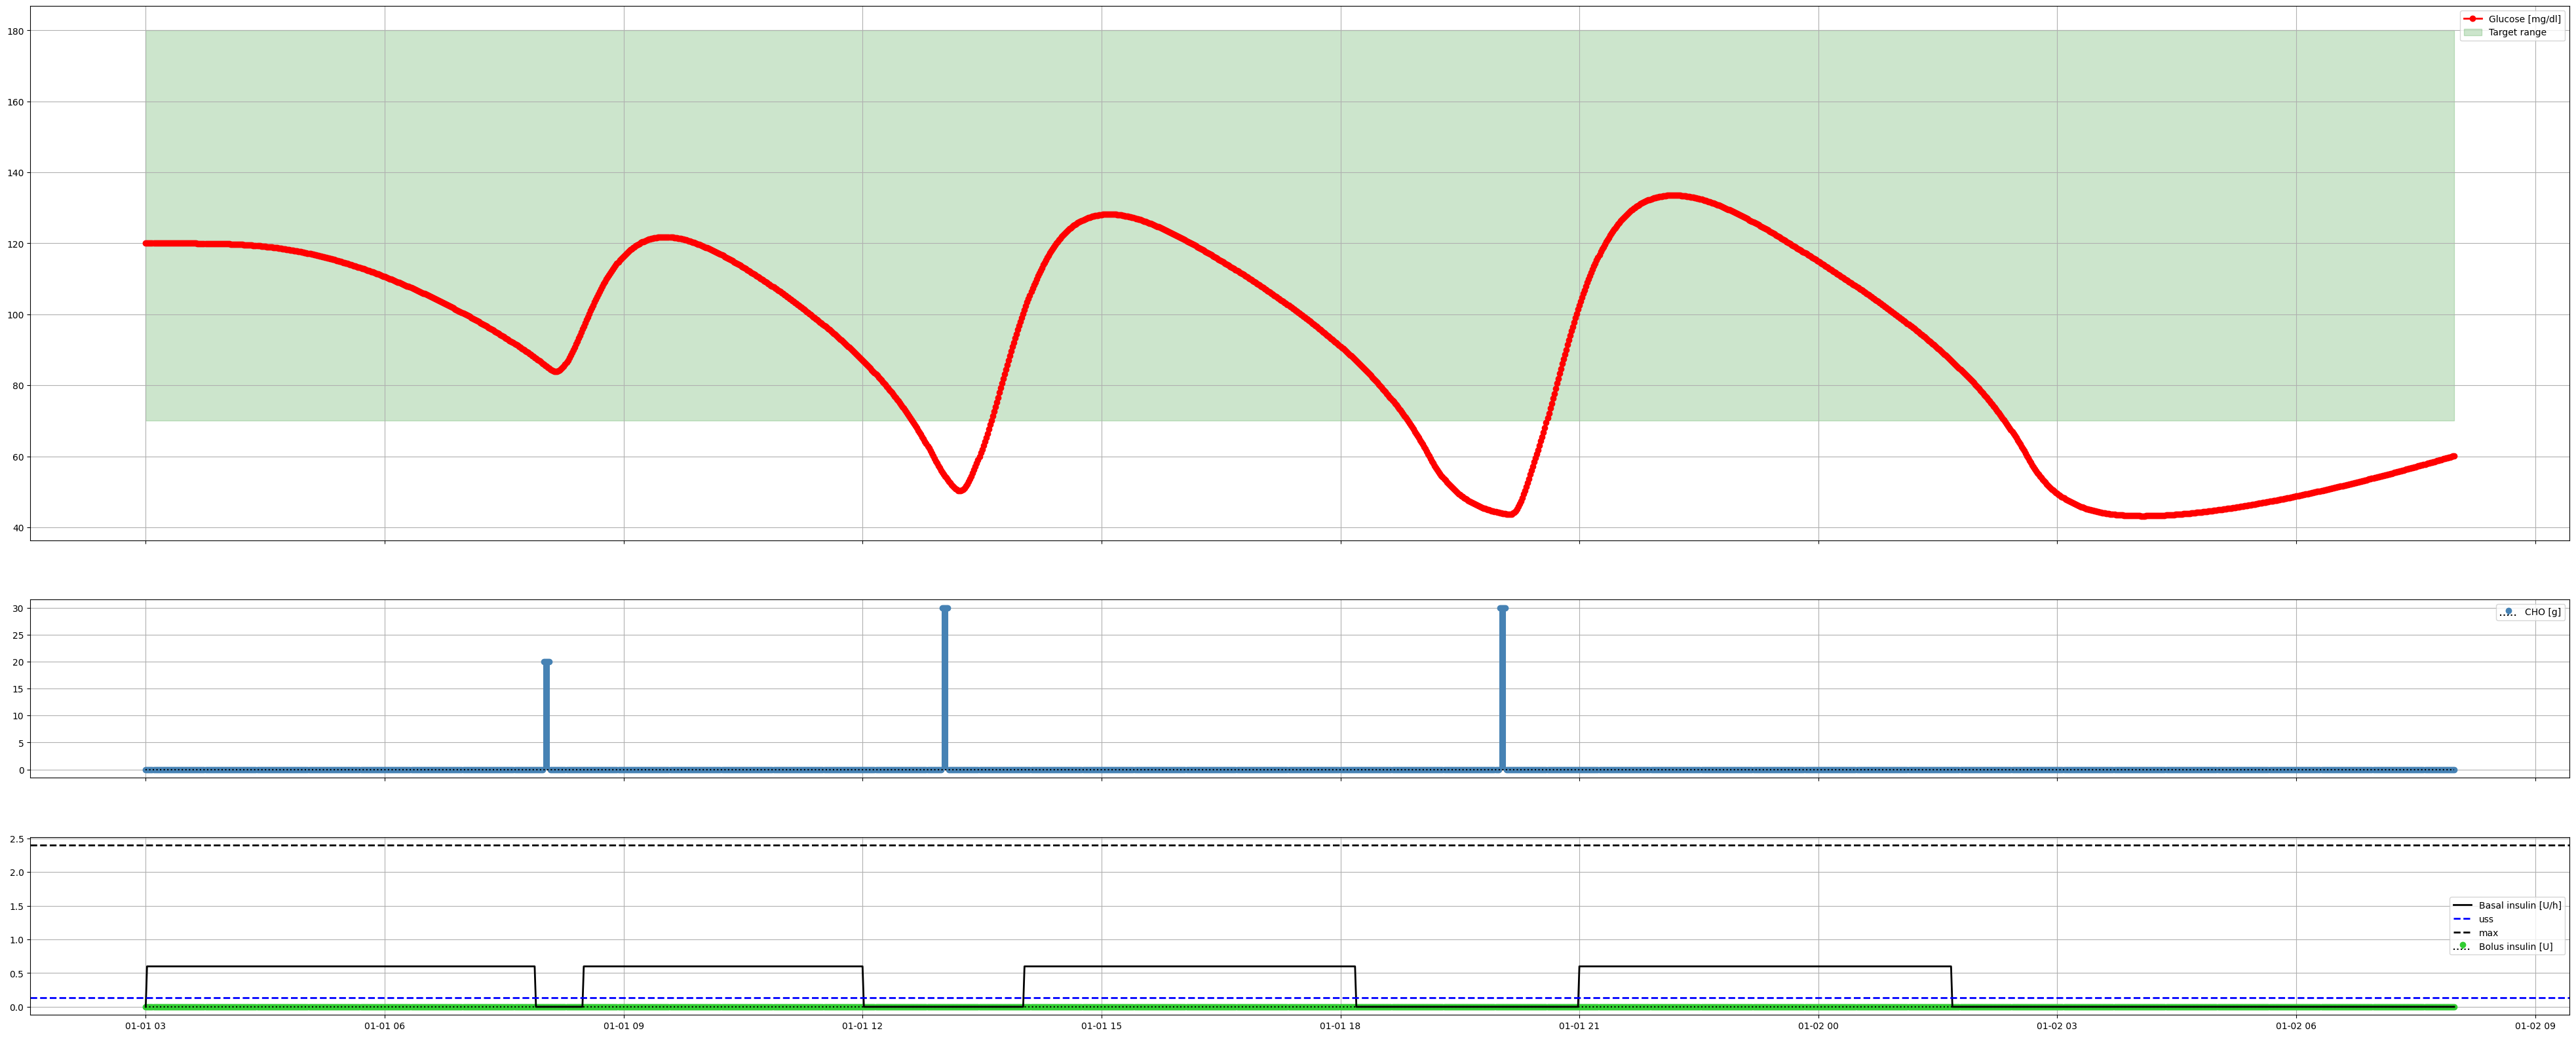

In [7]:
##################################### Example of displaying simulation results  ###################################

# You can create a dict() that will be accessible during simulation by your handler
basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

data_given = pd.read_csv('data/data_cho.csv')

glucose, i, insulin_bolus, m, time = simulate(basal_handler=basal_insulin_controller_example,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

# After simulation, you can evaluate glucose trace with AGATA.
# First, generate a dataframe that is compatible with AGATA https://github.com/gcappon/py_agata/
data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

# Then glucose trace can be analyzed with Agata().analyze_glucose_profile() 
agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

# ... or, if you need just 1 metric, you can use a metric such as time_in_target
TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

#Finally, a function to plot the simulation traces
plot_results(glucose=glucose, insulin_bolus=insulin_bolus, i=i, m=m, time=time)


## PID Controller

The following code initializes Insulin Co's PID controller. 

In [8]:
class PIDController:
    def __init__(self, Ki, Kd, Kp):
        self.Ki = Ki
        self.Kd = Kd
        self.Kp = Kp
        self.integral = 0
        self.prev_error = 0

        # Values to analyze the order of magnitude for MPC tuning
        self.xss = None
        self.uss = None
        self.x = np.zeros((9, ))
    
    def compute_pid(self, model, x0, tau, time_index, inputs_, xss, uss, dss):
        # Save states for MPC tuning
        if time_index == 0:
            self.xss = xss
            self.uss = uss
        else:
            self.x = np.vstack([self.x, x0])

        # Error calculation from the desired setpoint
        error = x0[8] - xss[8]
    
        # Integral, Derivative, and Proportional terms of PID
        self.integral += error * 1
        derivative = (error - self.prev_error) / 1
        self.prev_error = error
        
        # Calculate PID control output
        control_output = self.Ki * self.integral + self.Kd * derivative + self.Kp * error + uss
        
        # Ensure control output is within valid limits (e.g., non-negative)
        control_output = max(0, control_output)
        
        return control_output, dss

    def restart(self):
        self.integral = 0
        self.prev_error = 0

## Task 1: Current state 

Below demonstrates how InsulinCo's PID controller performs in a standard operating condition.

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'variability': {'mean_glucose': 122.72326132146536, 'median_glucose': 120.2520740123372, 'std_glucose': 26.72974323899601, 'cv_glucose': 21.780502694578203, 'range_glucose': 90.81435247972851, 'iqr_glucose': 44.46459618999555, 'auc_glucose': 213538.47469934972, 'gmi': 6.245540410809451, 'cogi': 98.54949330020047, 'conga': 42.29531309105667, 'j_index': 22.33620057214929, 'mage_plus_index': 46.505329150892365, 'mage_minus_index': 55.1123242933466, 'mage_index': 50.808826722119484, 'ef_index': 0.5, 'modd': 28.414001017145335, 'sddm_index': 25.050025824466008, 'sdw_index': 18.42286251128358, 'std_glucose_roc': 0.07815983041075796, 'cvga': 1100.460324050778}, 'time_in_ranges': {'time_in_target': 100.0, 'time_in_tight_target': 72.01149425287356, 'time_in_hypoglycemia': 0.0, 'time_in_l1_hypoglycemia': 0.0, 'time_in_l2_hypoglycemia': 0.0, 'time_in_hyperglycemia': 0.0, 'time_in_l1_hyperglycemia': 0.0, 'time_in_l2_hyperglycemia': 0.0}, 'risk': {'adrr': 6.626887792688376, 'lbgi': 0.4943573214042

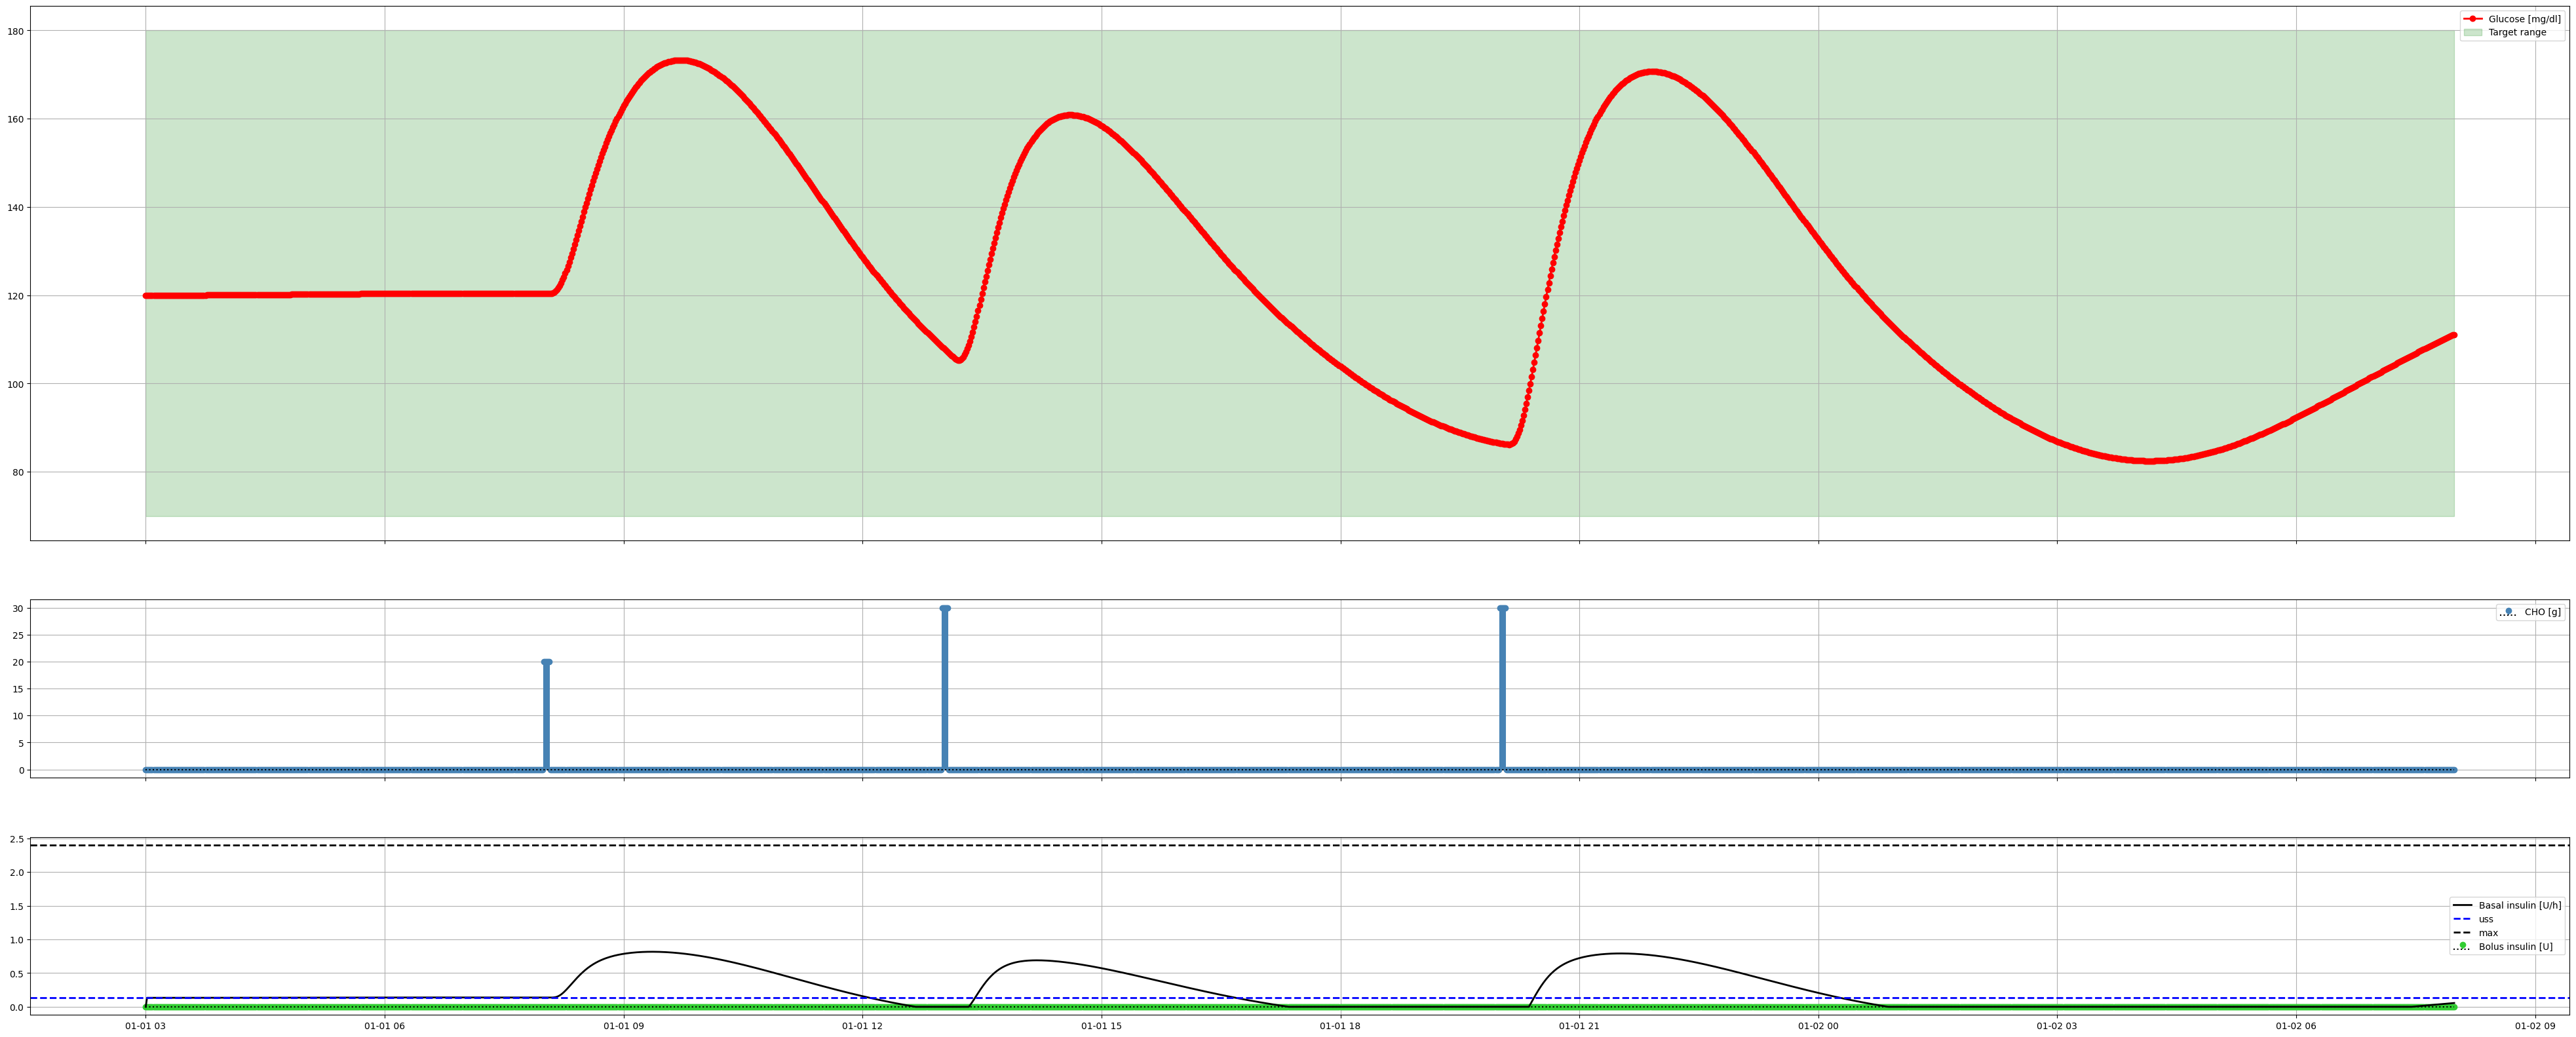

In [9]:
##################################### Demonstration of InsulinCo's PID control  ###################################

basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

# Get test data
data_given = pd.read_csv('data/data_cho.csv')

# Instatiating PID Controller
pid_controller = PIDController(Ki=0.0, Kd=0.005, Kp=0.0002)

# Running the simulation
glucose, i, insulin_bolus, m, time = simulate(basal_handler=pid_controller.compute_pid,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)

## Task 2: Failure Mode

Demonstrate a compelling failure scenario in which InsulinCo's PID controller fails to successfully regulate insulin to motivate a better controller.

### Implementation

InsulinCo is interested in controllers that can work with the *default meal values* as explained above. For this reason, the performance of the PID controller is evaluated with these values.

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\py_agata\variability\__init__.py:729: RuntimeWarning: Mean of empty slice
  mage_day_plus[d] = np.nanmean(excursions[excursions > 0])


TimeInTarget = 62.06896551724138%


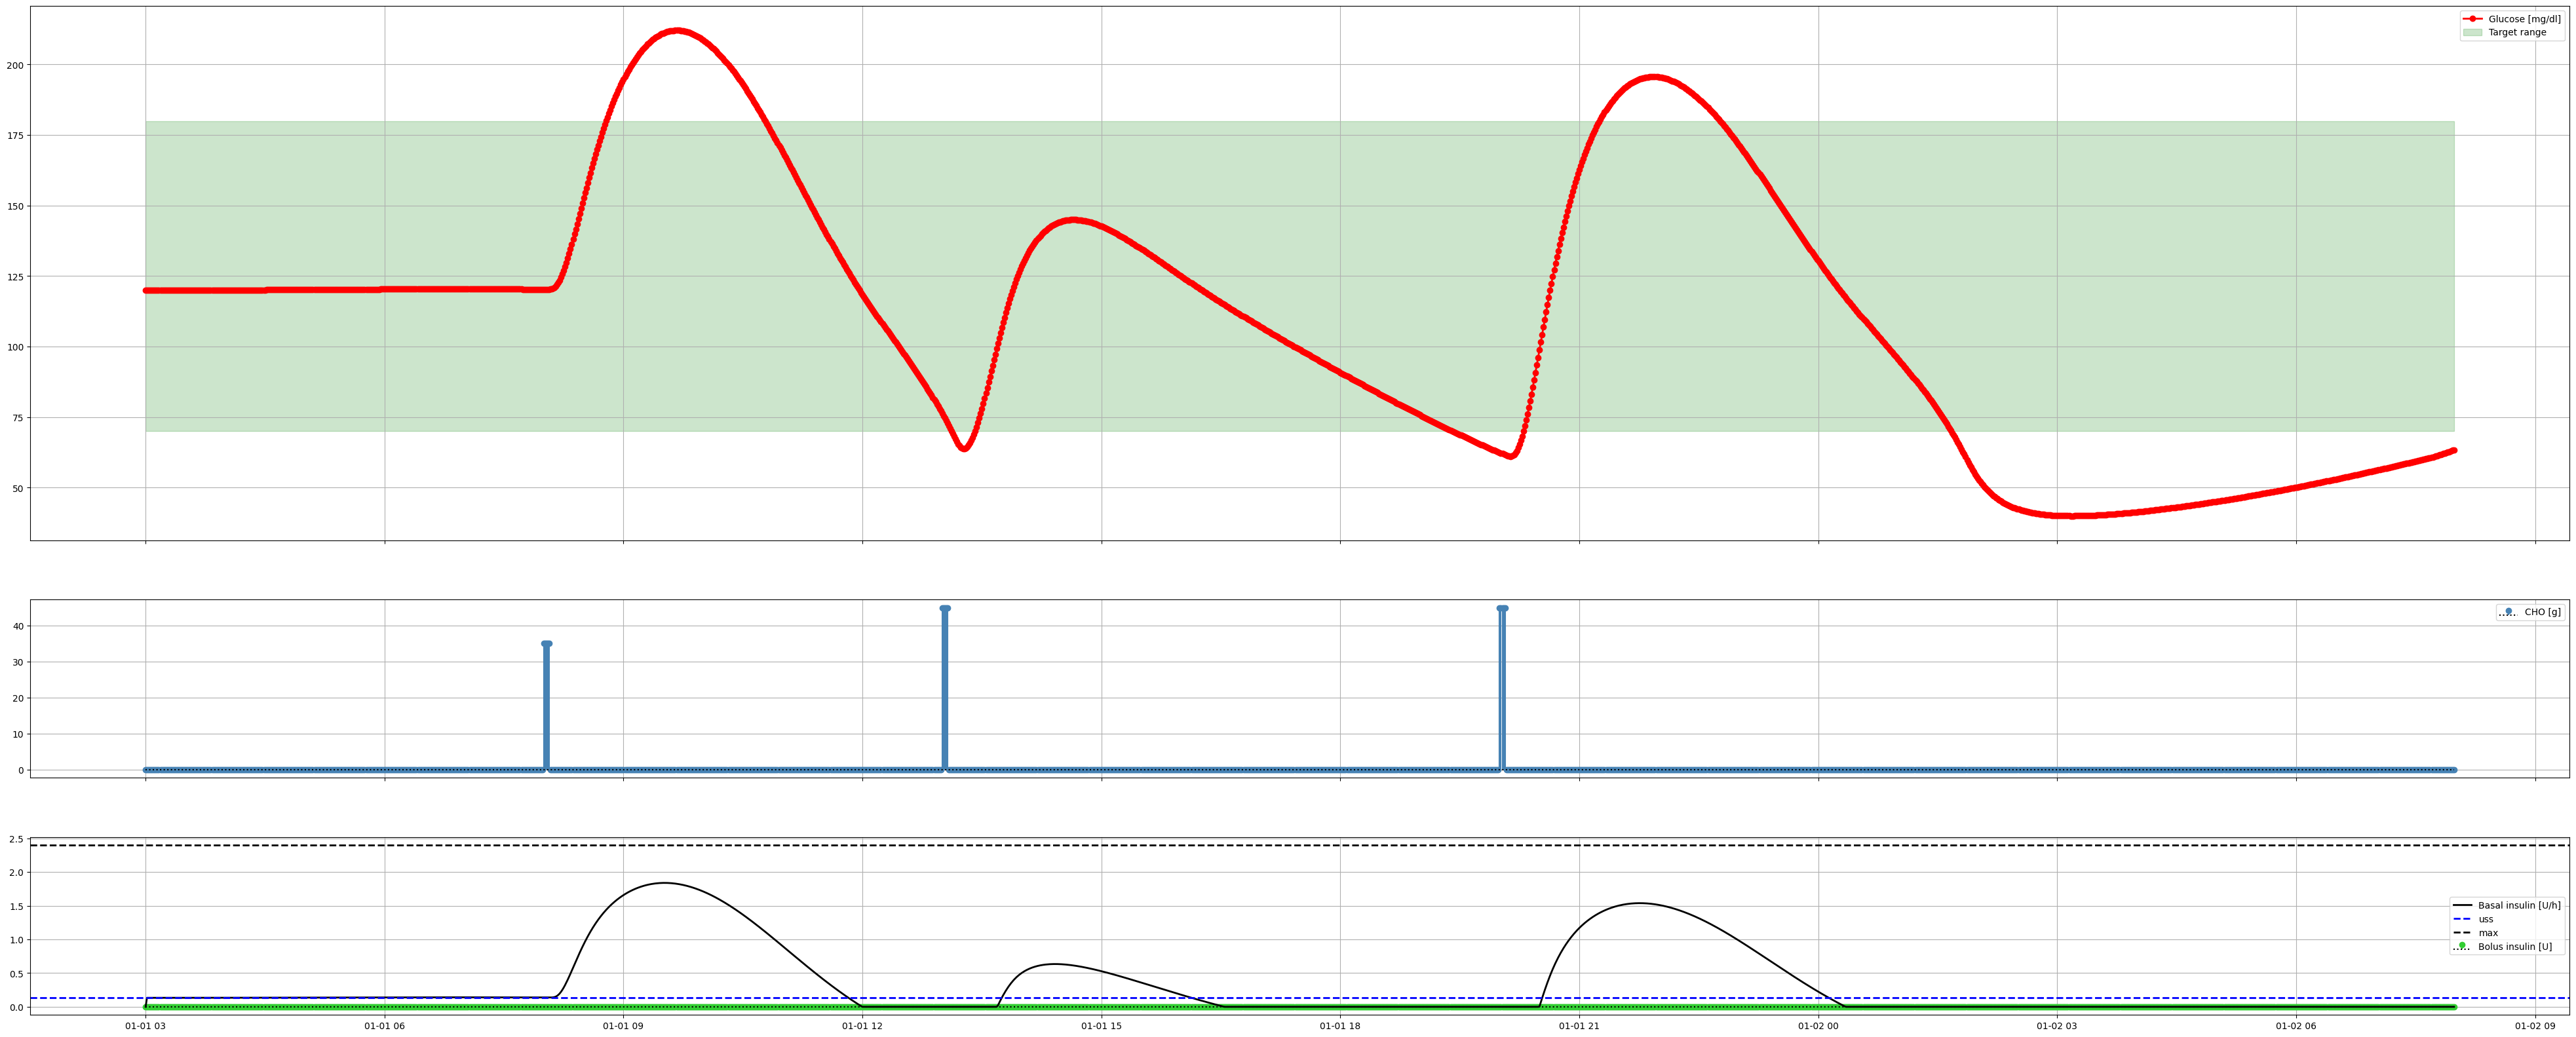

In [10]:
##################################### Failure mode of InsulinCo's PID control  ###################################
basal_handler_params = dict()
basal_handler_params['default_rate'] = 0.01

# Get test data
data_given = pd.read_csv('data/default_data.csv')

# Instatiating PID Controller
pid_controller = PIDController(Ki=0.0, Kd=0.005, Kp=0.0003)

# Running the simulation
glucose, i, insulin_bolus, m, time = simulate(basal_handler=pid_controller.compute_pid,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
# print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)

It is clear from the above plot that the soft and, more dangerously, the hard limits are being violated. This behaviour is expected as the PID is an unconstrained (*and not robust*) controller. As our task is both to ensure the safety of the patient (*in all situations*) and to respect the physical limitations of the insulin pumps, we are led to implement a (*robust*) controller that includes constraints.

(*it might be interesting to analyse cases where disturbances such as exercise, snacks, or meal of 140 g are taken into account, leading to a robust formulation*)

## Task 3: Model-Based Controller

Propose and implement a Model-Based controller, assuming that you access to the (linearized) system model described above and a full state measurement.

### Controller Choice
The points that motivates the choice of a tracking MPC (Model Predictive Control) are the following:
- (tracking): InsulinCo provides us with reference steady-state values for input and states,
- (Model): InsulinCo provides us with a linearized model,
- (Predictive): Our system has delay and we want to anticipate the rise of glucose due to future meals, and
- InsulinCo provides us with input and output constraints.

### Mathematical Description of Tracking MPC
We have the following Linear Time-Invariant (LTI) dynamics
$$\textbf{x}_{k+1} = A \textbf{x}_{k} + B\textbf{u}_{k} + h,$$

that can be expressed with respect to $\textbf{x}_0$ as
$$\textbf{x}_k = A^k \textbf{x}_0 + \sum_{i=0}^{k-1} A^{k-i-1} B \textbf{u}_i + A^{k-i-1} h.$$

Therefore, in order to account for the delay $\tau$, we firstly let the system evolve until $\textbf{x}_\tau$

$$\textbf{x}_\tau = A^\tau \textbf{x}_0 + \sum_{i=0}^{\tau-1} A^{\tau-i-1} B \textbf{u}_i + A^{\tau-i-1} h,$$

and use this value as initial condition to solve the following optimal control problem (OCP):
$$
\begin{array}{rll}
\min_{\textbf{x}, \textbf{u}_1} & \sum_{k=0}^{K-1} \|\textbf{x}_k - \textbf{x}_{ss} \|^2_Q + \|\textbf{u}_{1,k} - u_{ss} \|_r^2 + \|\textbf{x}_K - \textbf{x}_{ss} \|^2_S & \\
\text{s.t.} & \textbf{x}_{k+1} = A \textbf{x}_{k} + B \textbf{u}_{k} + h & k=0, \ldots, K-1 \\
& \textbf{x}_0 = \textbf{x}_\tau & \\
& 0 \leq \textbf{u}_{1,k} \leq 0.04 & k=0, \ldots, K - 1 \\
& \textbf{x}_{9,k} \geq 70 & k=0, \ldots, K - 1
\end{array}
$$

where
- the objective function is to minimize the deviations from the steady-state input $u_{ss}$ and states $\textbf{x}_{ss}$,
- $K \in \mathbb{R}_{\geq 0}$ is the prediction horizon,
- $\textbf{x}_k$ represents the nine-dimensional state at time $k$,
- $\textbf{u}_k = \begin{bmatrix}i_k & m_k \end{bmatrix}^T$ represents the two-dimensional input at time $k$,
- $Q \in \mathbb{R}^{9\times9}_{\geq 0}$ penalyzes the states at all future times until $K - 1$,
- $S \in \mathbb{R}^{9\times9}_{\geq 0}$ penalyzes the states at time $K$ in the future,
- $r \in \mathbb{R}_{\geq 0}$ penalyzes the controllable input $i_k$,
- $A \in \mathbb{R}^{9\times9}$ is the dynamics matrix,
- $B \in \mathbb{R}^{9\times2}$ is the input matrix,
- $h \in \mathbb{R}^{9\times1}$ is the offset constant produced by the linearization,
- $\textbf{x}_\tau$ represents the initial condition,
- $0 \leq \textbf{u}_{1,k} \leq 0.04$ are the input constraints for insulin injection, and
- $\textbf{x}_{9,k} \geq 70$ mg/dl represents the hard constraint for hypoglicemia.

### Implementation Description
In order to minimize the computational effort of running the simulation using MPC, we ensure that the OCP is [Disciplined Parametrized Programming (DPP)](https://www.cvxpy.org/tutorial/dpp/index.html) and also [Disciplined Convex Programming (DCP)](https://www.cvxpy.org/tutorial/dcp/) compliant. This is achieved by considering the following points:
- the OCP is parametrized and constructed only once,
- the cost function is quadratic and therefore convex, and
- the constraints are linear or follow the rules for DPP.

Additionally, we have to constraint that our uncontrollable input reflects the future meal obtained using ```get_discretized_meals()```.

Therefore, the OCP becomes
$$
\begin{array}{rll}
\min_{\textbf{x}, \textbf{u}_1} & \sum_{k=0}^{K-1} \|\textbf{x}_k - \textbf{x}_{ss} \|^2_Q + \|\textbf{u}_{1,k} - u_{ss} \|_r^2 + \|\textbf{x}_K - \textbf{x}_{ss} \|^2_S & \\
\text{s.t.} & \textbf{x}_{k+1} = A \textbf{x}_{k} + B \textbf{u}_{k} + h & k=0, \ldots, K-1 \\
& \textbf{x}_0 = \textbf{x}_\tau & \\
& \textbf{u}_{2,k} = m_k & k=0, \ldots, K - 1 \\
& \textbf{u}_{1,k} \geq 0 & k=0, \ldots, K - 1 \\
& \textbf{u}_{1,k} \leq 0.04 & k=0, \ldots, K - 1 \\
& \textbf{x}_{9,k} \geq 70 & k=0, \ldots, K - 1
\end{array}
$$

In [11]:
print("Available solvers in CVXPY:", cp.installed_solvers())

Available solvers in CVXPY: ['CLARABEL', 'DIFFCP', 'ECOS', 'ECOS_BB', 'MOSEK', 'OSQP', 'SCIPY', 'SCS']


In [27]:
class TrackingMPController:
    def __init__(self, Q:np.ndarray, S:np.ndarray, r:float, K:int, control_horizon:int, print_output:bool=False, verbose:bool=False) -> None:
        self.Q = Q
        self.S = S
        self.r = r
        self.K = K
        self.control_horizon = control_horizon

        self.n = 9
        self.m = 2

        self.print_output = print_output
        self.verbose = verbose
        self.num_infeas = 0
        self.num_None_output = 0

        self._init_optimization_problem()

    def _init_optimization_problem(self) -> None:
        """
        Initialize the parametrized optimization problem and its components.
        """
        # Define variables and dynamic parameters for the optimization problem
        self.x_var = cp.Variable((self.n, self.K+1))
        self.i_var = cp.Variable((1, self.K))
        self.m_var = cp.Variable((1, self.K))
        self.meal_param = cp.Parameter(self.K)
        self.x0_param = cp.Parameter(self.n)

        # Placeholders for parametrization
        self.A = cp.Parameter((self.n, self.n))
        self.B = cp.Parameter((self.n, self.m))
        self.h = cp.Parameter(self.n)
        self.xss = cp.Parameter(self.n)
        self.uss = cp.Parameter()

        # Initialize cost and constraints (parametrized)
        self.cost = 0
        self.constraints = [self.x_var[:, 0] == self.x0_param]
        
        # Iterate over the horizon K - 1 for cost and constraints
        for k in range(self.K):
            self.cost += (
                cp.quad_form(self.x_var[:, k] - self.xss, self.Q) + 
                cp.square(self.i_var[0, k] - self.uss) * self.r
                )
            self.constraints += [
                self.x_var[:, k+1] == self.A @ self.x_var[:, k] + self.B[:, 0] * self.i_var[0, k] + self.B[:, 1] * self.m_var[0, k] + self.h,
                self.m_var[0, k] == self.meal_param[k], # make it DPP compliant
                self.i_var[0, k] >= 0,
                self.i_var[0, k] <= 0.04,
                self.x_var[8, k] >= 70,
                ]
        
        # Terminal cost or constraint for stability
        self.cost += cp.quad_form(self.x_var[:, self.K] - self.xss, self.S)
        # self.constraints += [self.x_var[:, self.K] == self.xss]

        self.problem = cp.Problem(cp.Minimize(self.cost), self.constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _update_model_params(self, A, B, h) -> None:
        """
        Update the parametrized model parameters for the optimization problem.
        """
        self.A.value = A
        self.B.value = B
        self.h.value = h

    def compute_mpc(self, model, x0, tau, time_index, inputs_, xss, uss, dss) -> tuple:
        """
        Implements the tracking MPC controller.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        
        # Update model parameters at the beginning of the simulation
        if time_index == 0:
            self._update_model_params(*model.get_linearization(1, x0))
            self.xss.value = xss
            self.uss.value = uss

            # Initialize the open-loop input
            dss.basal_handler_params['open-loop input'] = uss * np.ones(len(inputs_))
        
        # Optimization at every control horizon
        if (time_index % self.control_horizon) == 0:
            # Linearization
            # self._update_model_params(*model.get_linearization(1, x0))

            meal = model.get_discretized_meals(initial_time_step=time_index, duration=self.K+tau, T=1)
            
            # Evolve the system to include the delay
            u_tau = np.vstack([
                inputs_[time_index:time_index+tau],
                meal[:tau]
                ])
            
            for k in range(tau):
                x0 = self.A.value @ x0 + self.B.value @ u_tau[:, k] + self.h.value
            
            # Update parameters for the optimization problem
            self.meal_param.value = meal[tau:]
            self.x0_param.value = x0

            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.i_var.value is None:
                    self.num_None_output += 1
                    raise Exception("Solver did not find a feasible solution.")
            
            except:
                self.num_infeas += 1
                
                control_output = dss.basal_handler_params['open-loop input'][time_index % self.control_horizon]

                if self.print_output:
                    print(f"Forced control output: {control_output}")
                return control_output, dss
            
            # Problem solved
            control_output = self.i_var[0, 0].value
            dss.basal_handler_params['open-loop input'] = self.i_var[0, :self.K].value

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            control_output = dss.basal_handler_params['open-loop input'][time_index % self.control_horizon]
            
            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

### Design/Tuning Parameters
#### Prediction Horizon $K$
It needs to be long enough to make sure that the MPC correctly anticipates the meal intakes and captures both the delay and the dynamics of the system.
- $K = 140$ min, but could be taken larger.

#### Control Horizon $T_\text{control}$
It defines how often the OCP is solved. Increasing $T_\text{control}$ reduces the computational effort and speeds up the simulation. Between two consecutive OCP solutions, the previously calculated control outputs are used.
- $T_\text{control} = 2$ min, as the computations are efficient due to the problem being DPP compliant.

#### 9 Diagonal Values of $Q$, 9 Diagonal Values of $S$, and Input Parameter $r$
These parameters penalize the squared deviation from the steady-state. The range of order magnitudes of the squared deviations of states and input is large. Therefore, to ensure that the effect on the cost function of all states and input is visible, we include a normalization with respect to $\Delta \textbf{x}_9^2 = (\hat{\textbf{x}}_9 - \textbf{x}_{ss})^2$. Here, $\hat{\textbf{x}}$ refers to the maximal value obtained when running the PID controller.
  - $Q = S = \begin{bmatrix} 1 & 0 & 1 & 1 & 1 & 1 & 1 & 0 & 10 \end{bmatrix} \cdot Q_\mathrm{normalization}$.
    - With $Q_\mathrm{normalization} = \Delta x_9^2 / \Delta \textbf{x}^2 = \Delta x_9^2 / \begin{bmatrix} \Delta x_1^2 & \ldots & \Delta x_9^2 \end{bmatrix}$.
    - The weights of the second and eighth states are set to zero because their normalization is too large and influences the costs excessively, leading to problems with the solver.
  - $r = 0.5 \cdot r_\mathrm{normalization}$.
    - With $r_\mathrm{normalization} = \Delta x_9^2 / (0.04 - u_{ss})^2$.

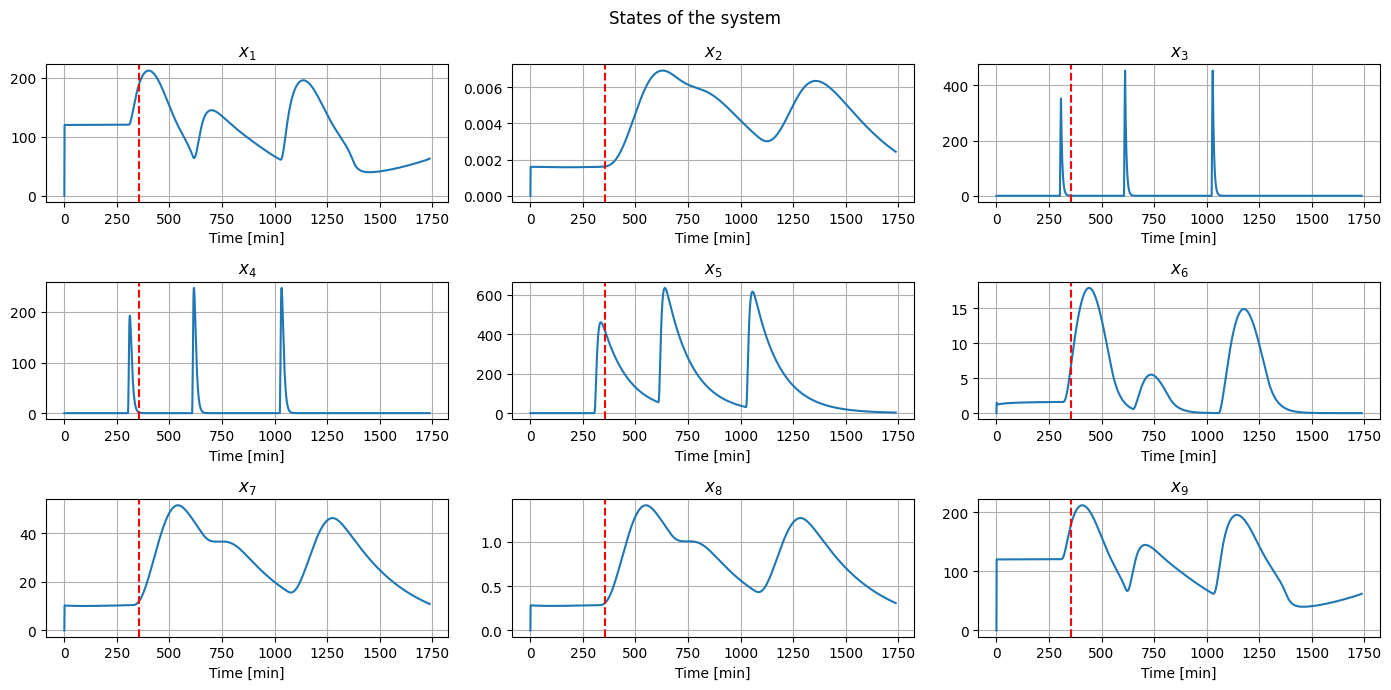

,x1,x2,x3,x4,x5,x6,x7,x8,x9
x_ss,120.000000,1.601439e-03,0.000000,0.000000,0.000000,1.508147,10.273468,0.282689,120.000000
x_max,212.109026,6.922945e-03,453.944180,247.563177,635.803343,17.874357,51.505054,1.413693,211.559972
Dx,92.109026,5.321506e-03,453.944180,247.563177,635.803343,16.366210,41.231586,1.131004,91.559972
Dx^2,8484.072753,2.831843e-05,206065.318973,61287.526683,404245.890663,267.852841,1700.043715,1.279171,8383.228439
Q_norm,0.988114,2.960344e+08,0.040682,0.136785,0.020738,31.297889,4.931184,6553.642419,1.000000


,i
u_ss,2.225892e-03
Di^2,1.426883e-03
r_norm,5.875203e+06


In [51]:
##################################### Weights Estimation - Normalization ###################################
states = pid_controller.x
time_simulation = np.arange(0, states.shape[0], 1)

# Find the time when x[8] reaches 180 mg/dl
time_180 = np.where(states[:, 8] >= 180)[0][0]

# Plot the states in 9 subplots
fig, axs = plt.subplots(3, 3, figsize=(14, 7))
fig.suptitle('States of the system')

for i in range(9):
    axs[i//3, i%3].plot(time_simulation, states[:, i])
    axs[i//3, i%3].set_title(r'$x_{}$'.format(i+1))
    axs[i//3, i%3].set_xlabel('Time [min]')
    axs[i//3, i%3].grid()
    axs[i//3, i%3].axvline(x=time_180, color='r', linestyle='--', label=r'$x_9 = 180$ mg/dl')

plt.tight_layout()
plt.show()
plt.close()

# For Q (and S)
xss = pid_controller.xss

column_names = [f'x{i}' for i in range(1, len(xss) + 1)]
df_x = pd.DataFrame((xss).reshape(-1,9), columns=column_names, index=['x_ss'])

x_max = np.max(pid_controller.x, axis=0)

df_x = pd.concat([df_x, pd.DataFrame((x_max).reshape(-1,9), columns=column_names, index=['x_max'])])
df_x = pd.concat([df_x, pd.DataFrame((x_max - xss).reshape(-1,9), columns=column_names, index=['Dx'])])
delta_x_square = (x_max - xss)**2
df_x = pd.concat([df_x, pd.DataFrame(delta_x_square.reshape(-1,9), columns=column_names, index=['Dx^2'])])
normalization_Q = delta_x_square[8] / delta_x_square
df_x = pd.concat([df_x, pd.DataFrame(normalization_Q.reshape(-1,9), columns=column_names, index=['Q_norm'])])
display(df_x)

# For r
uss = pid_controller.uss

df_i = pd.DataFrame(uss, columns=['i'], index=['u_ss'])

delta_i_square = (0.04 - uss)**2
df_i = pd.concat([df_i, pd.DataFrame(delta_i_square, columns=['i'], index=['Di^2'])])
normalization_r = delta_x_square[8] / delta_i_square
df_i = pd.concat([df_i, pd.DataFrame(normalization_r, columns=['i'], index=['r_norm'])])
display(df_i)

In [ ]:
class TrackingMPController_discrete:
    def __init__(self, Q:np.ndarray, S:np.ndarray, r:float, s:float, K:int, control_horizon:int, print_output:bool=False, verbose:bool=False) -> None:
        self.Q = Q
        self.S = S
        self.r = r
        self.K = K
        self.control_horizon = control_horizon
        self.s = s

        self.n = 9
        self.m = 2

        self.print_output = print_output
        self.verbose = verbose
        self.num_infeas = 0
        self.num_None_output = 0

        self._init_optimization_problem()

    def _init_optimization_problem(self) -> None:
        """
        Initialize the parametrized optimization problem and its components.
        """
        # Define variables and dynamic parameters for the optimization problem
        self.x_var = cp.Variable((self.n, self.K+1))
        self.i_var = cp.Variable((1, self.K))
        self.m_var = cp.Variable((1, self.K))
        self.meal_param = cp.Parameter(self.K)
        self.x0_param = cp.Parameter(self.n)
        self.slack_x_ub_var = cp.Variable(self.K)

        # Placeholders for parametrization
        self.A = cp.Parameter((self.n, self.n))
        self.B = cp.Parameter((self.n, self.m))
        self.h = cp.Parameter(self.n)
        self.xss = cp.Parameter(self.n)
        self.uss = cp.Parameter()

        # Initialize cost and constraints (parametrized)
        self.cost = 0
        self.constraints = [self.x_var[:, 0] == self.x0_param]
        
        # Iterate over the horizon K - 1 for cost and constraints
        for k in range(self.K):
            self.cost += (
                cp.quad_form(self.x_var[:, k] - self.xss, self.Q) + 
                cp.square(self.i_var[0, k] - self.uss) * self.r +
                cp.square(self.slack_x_ub_var[k]) * self.s
                )
            self.constraints += [
                self.x_var[:, k+1] == self.A @ self.x_var[:, k] + self.B[:, 0] * self.i_var[0, k] + self.B[:, 1] * self.m_var[0, k] + self.h,
                self.m_var[0, k] == self.meal_param[k], # make it DPP compliant with meal as variable
                self.i_var[0, k] >= 0,
                self.i_var[0, k] <= 0.04,
                self.x_var[8, k] >= 70,
                self.x_var[8, k] <= 180 + self.slack_x_ub_var[k],
                self.slack_x_ub_var[k] >= 0,
                ]
        
        # Terminal cost or constraint for stability
        # self.cost += cp.quad_form(self.x_var[:, self.K] - self.xss, self.S)
        self.constraints += [self.x_var[:, self.K] == self.xss]

        self.problem = cp.Problem(cp.Minimize(self.cost), self.constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _update_model_params(self, A, B, h) -> None:
        """
        Update the parametrized model parameters for the optimization problem.
        """
        self.A.value = A
        self.B.value = B
        self.h.value = h

    def compute_mpc(self, model, x0, tau, time_index, inputs_, xss, uss, dss) -> tuple:
        """
        Implements the tracking MPC controller.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        
        # Update model parameters at the beginning of the simulation
        if time_index == 0:
            self._update_model_params(*model.get_linearization(1, x0))
            self.xss.value = xss
            self.uss.value = uss

            # Initialize the open-loop input
            dss.basal_handler_params['open-loop input'] = uss * np.ones(len(inputs_))
        
        # Optimization at every control horizon
        if (time_index % self.control_horizon) == 0:
            # Linearization
            # self._update_model_params(*model.get_linearization(1, x0))

            meal = model.get_discretized_meals(initial_time_step=time_index, duration=self.K+tau, T=1)
            
            # Evolve the system to include the delay
            u_tau = np.vstack([
                inputs_[time_index:time_index+tau],
                meal[:tau]
                ])
            
            for k in range(tau):
                x0 = self.A.value @ x0 + self.B.value @ u_tau[:, k] + self.h.value
            
            # Update parameters for the optimization problem
            self.meal_param.value = meal[tau:]
            self.x0_param.value = x0
        
            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.i_var.value is None:
                    raise Exception("Solver did not find a feasible solution.")
            
            # Fallback solver
            except:
                try:
                    self.problem.solve(solver=cp.CLARABEL, verbose=self.verbose)

                    # Check if the solution is available
                    if self.i_var.value is None:
                        self.num_None_output += 1
                        raise Exception("Fallback solver did not find a feasible solution.")

                except:
                    self.num_infeas += 1
                    
                    control_output = dss.basal_handler_params['open-loop input'][time_index % self.control_horizon]

                    if self.print_output:
                        print(f"Forced control output: {control_output}")
                    return control_output, dss
            
            # Problem solved
            control_output = self.i_var[0, 0].value
            dss.basal_handler_params['open-loop input'] = self.i_var[0, :self.K].value

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            control_output = dss.basal_handler_params['open-loop input'][time_index % self.control_horizon]
            
            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

Is the problem DPP compliant? True
Is the problem DCP compliant? True
------ START ------
--  Simulation time: 0 min  -  Infeasible solutions: 0 of which None output: 0  --
Forced control output: 0.0022258920478113974
--  Simulation time: 1 min  -  Infeasible solutions: 1 of which None output: 0  --
Forced control output: 0.0022258920478113974
--  Simulation time: 2 min  -  Infeasible solutions: 2 of which None output: 0  --
Optimized control output: 0.0029332732876193868
--  Simulation time: 3 min  -  Infeasible solutions: 2 of which None output: 0  --
Optimized control output: 0.002886853215172902
--  Simulation time: 4 min  -  Infeasible solutions: 2 of which None output: 0  --
Forced control output: 0.002886853215172902
--  Simulation time: 5 min  -  Infeasible solutions: 3 of which None output: 0  --
Forced control output: 0.002886853215172902
--  Simulation time: 6 min  -  Infeasible solutions: 4 of which None output: 0  --
Forced control output: 0.002886853215172902
--  Simulati

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TimeInTarget = 100.0%


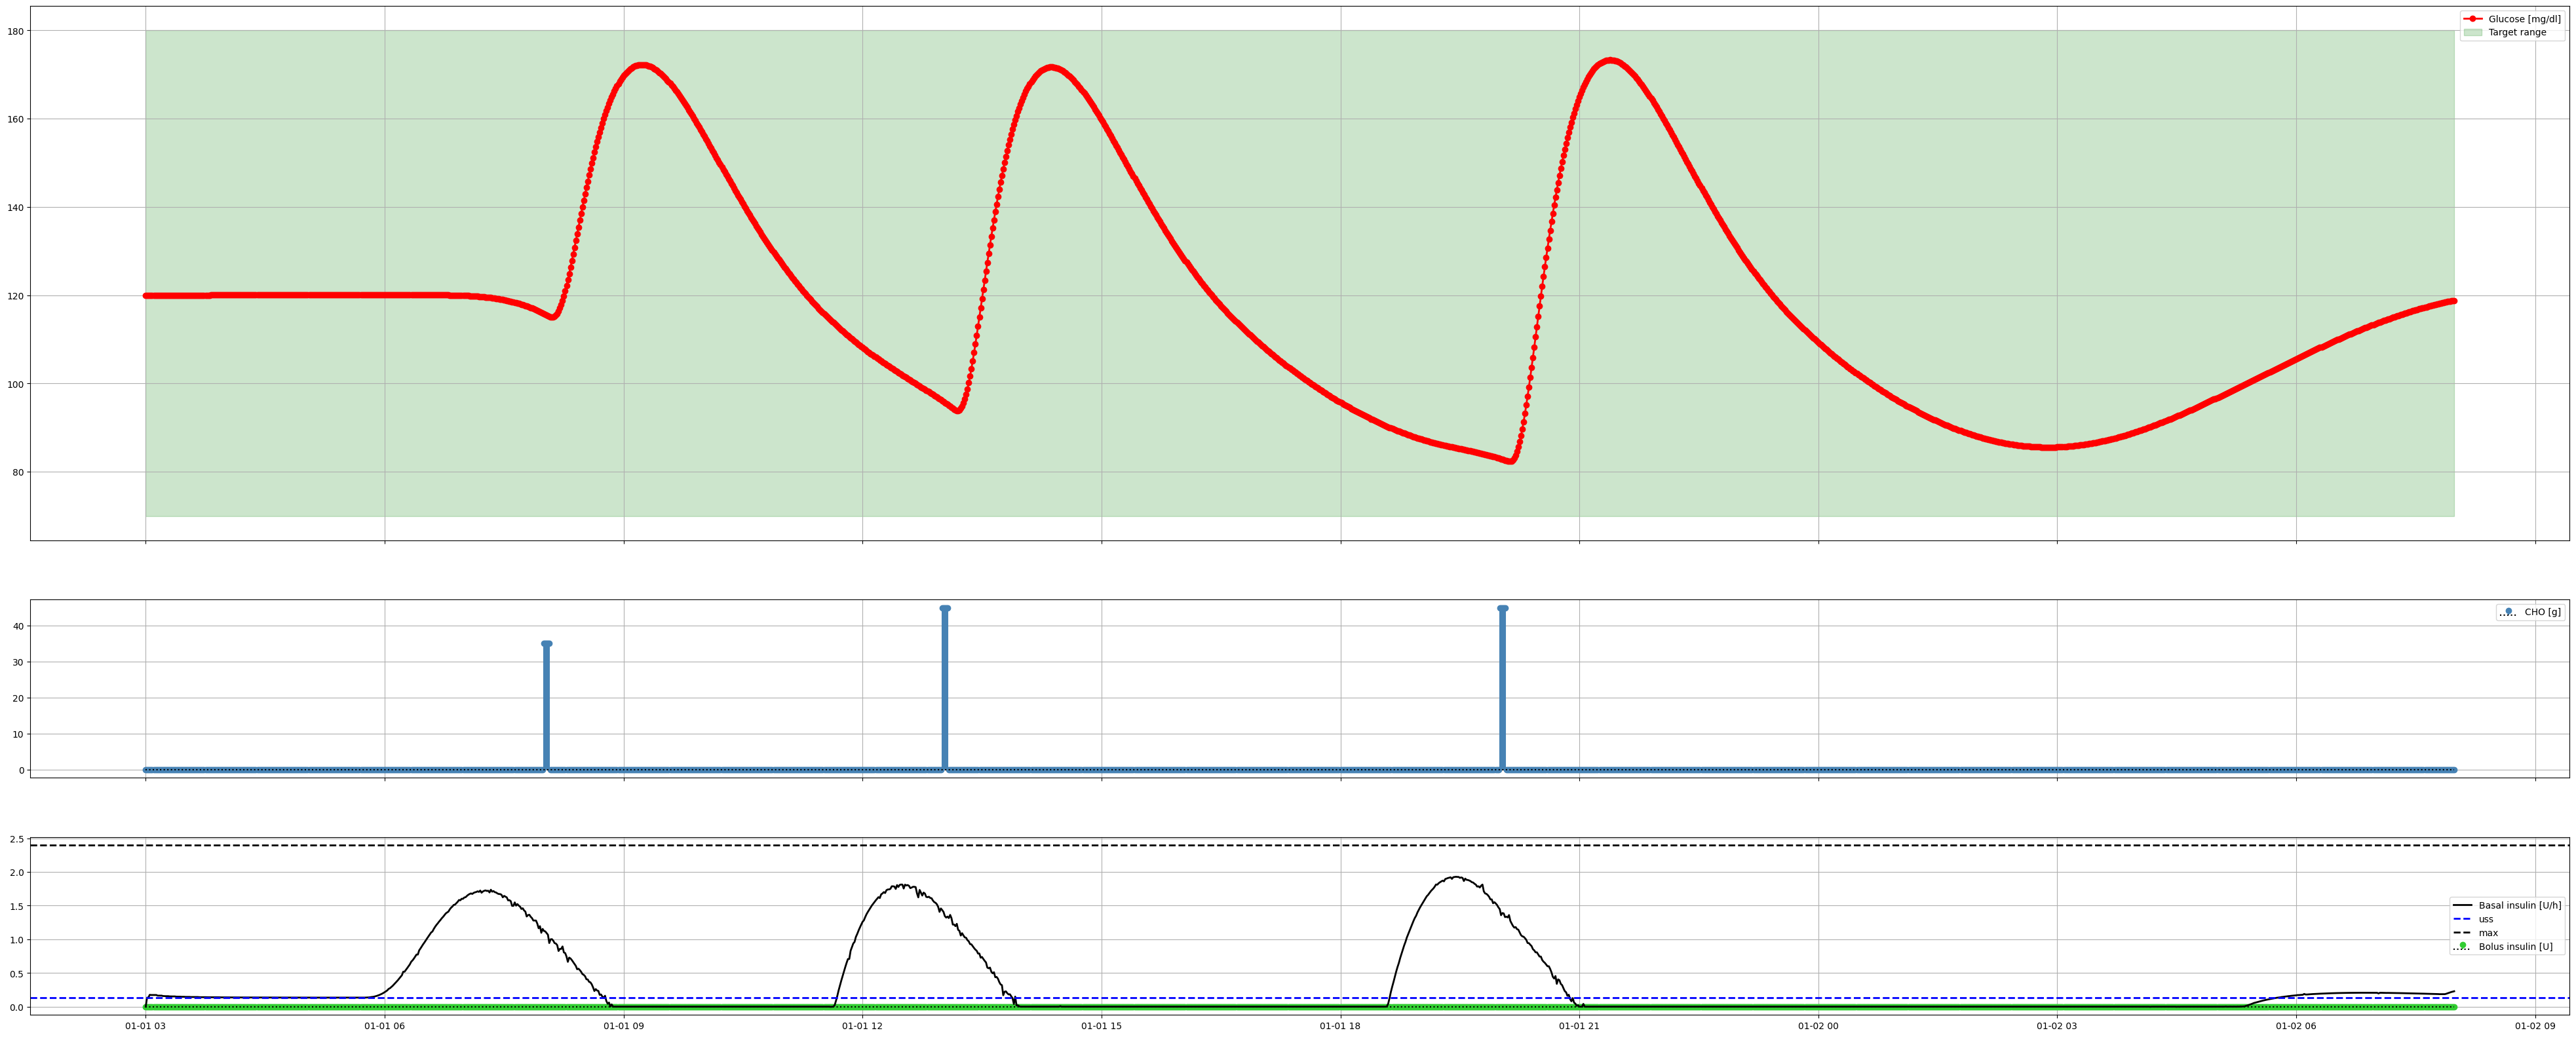

In [29]:
##################################### Tracking MPC ###################################
# Initialize the dict to save inputs
basal_handler_params = dict()
basal_handler_params['open-loop input'] = None

# Get the data
# data_given = pd.read_csv('data/zero_test.csv')
# data_given = pd.read_csv('data/easy_test.csv')
# data_given = pd.read_csv('data/data_cho.csv')
data_given = pd.read_csv('data/default_data.csv')

# Instatiating tracking MPC
Q = np.diag([1, 0, 1, 1, 1, 1, 1, 0, 10]) * normalization_Q
r = 0.5 * normalization_r
S = Q
control_horizon = 2 # increase to reduce computation time
K = 140
# s = 0.0 # increase to penalize the soft constraint
print_output = True
tracking_mpc = TrackingMPController(Q, S, r, K, control_horizon, print_output=print_output)

# Running the simulation
print("------ START ------")
glucose, i, insulin_bolus, m, time = simulate(basal_handler=tracking_mpc.compute_mpc,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)
print("------ FINISH ------")

data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
# print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)

### Possible Improvements
- In order to ensure stability as seen in class, we could have inserted the terminal constraint $\textbf{x}_K = \textbf{x}_{ss}$.
- In order to penalize the soft constraint of hyperglicemia, we could have inserted a slack variable. With the current controller we reach 100% time-in-target, so it was not included.
- Include a discretization to speed up the results and allow $K$ to be even larger.
- Investigate the impact of different solvers on speed and infeasible solutions (at the moment MOSEK is the best).

## Task 4: Data-enabled Predictive Control

Propose and implement a DeePC controller, assuming that you measure the glucose $G(t)$ and the “non-monomatic” or “inactive insulin” $I_{sc1}$ (in practice, $I_{sc1}$ cannot be measured. Removing this measurement is one option for the bonus). Use the data that InsulinCo has provided to you as the training data.

The file `DeePC_data.pkl` contains a pandas data frame with 4 columns:
- $m(t)$ (u[1]): Carbohydrate intake/"meals" (uncontrolled)
- $I(t)$ (u[0]): Exogenous/Basal insulin injections (controlled)
- $I_{sc1}(t)$ (x[5]): the insulin in a non-monomeric state 
- $G(t)$ (x[8]): the interstitial glucose concentration

Every row is a different time step corresponding to 1 minute intervals.

To discretize the meals in a way that is equivalent to `get_discretized_meals`, you should add all the meals in a given interval. For example, if one uses a time-discretization of 5 minutes, the meals vector entry for the first control timestep should be m[0] = sum(meal[0:5]), and for the second control timestep m[1] = sum(meal[5:10]). For the input, you might want to use the average, i.e., i[0] = avg(input[0:5]), though that is a design decision that is up to you.

Also note that you may not need to use all the timesteps in the file.

To load the dataframe, you can use the following line:
`df = pd.read_pickle("DeePC_data.pkl")`
which loads the dataframe into the variable "df".

To solve the optimization problem, we advise you to use the MOSEK solver ```problem.solve(solver=cp.MOSEK')```, though you are welcome to use other solvers.

<div>
    <img src="Trajectory.png" width="500"/>
</div>

In [30]:
##################################### Estimation of the lag ###################################
data = pd.read_csv('data/default_data.csv')
data.t = pd.to_datetime(data['t'], format='mixed')

t1d_model = T1DModel(data=data,
                     bw=62.0,
                     yts=5,
                     glucose_model='IG',
                     is_single_meal=False,
                     exercise=False)

x0 = np.array([120.0, 0.0016, 0.0, 0.0, 0.0, 1.5081, 10.2735, 0.2827, 120.0])
A, B, h = t1d_model.get_linearization(1, x0)
C = np.array([0, 0, 0, 0, 0, 1, 0, 0, 1])

# Find lag of the linearized MIMO system
Obsv = C
A_pow = A
n = 9
lag = 0

for i in range(1, 11):
    # Check rank of the updated observability matrix
    rank = np.linalg.matrix_rank(Obsv)
    print(f"Rank of obsv at {i}: {rank}")

    if rank == n:
        lag = i
        break
    
    # Compute the next block C * A^i
    Obsv = np.vstack((Obsv, C @ A_pow))
    A_pow = A_pow @ A

print(f"Lag of the system: {lag}")

Rank of obsv at 1: 1
Rank of obsv at 2: 2
Rank of obsv at 3: 3
Rank of obsv at 4: 4
Rank of obsv at 5: 5
Rank of obsv at 6: 6
Rank of obsv at 7: 7
Rank of obsv at 8: 8
Rank of obsv at 9: 8
Rank of obsv at 10: 8
Lag of the system: 0


In [31]:
##################################### Hankel rank investigation ###################################
# Dimensions
n = 9 # assumed as unknown
m = 2
p = 2

# Set Hankel dimensions
T_past = 12 # should be at least lag for MIMO and n for SISO
K = 140 # high prediction horizon
T_fut = K
L = T_past + T_fut
T = 530 # large
num_hankel_cols = T - L + 1
print("T_min:", (m + 1) * (T_past + L) + n - 1)
print("T:", T)
print("L:", L)

# Collect data
data = pd.read_pickle("data/DeePC_data.pkl")
data.to_csv(os.path.join(os.path.abspath(''), 'data', 'DeePC_data.csv'))

# Extract individual time series data
y1_data = data["x_8"].to_numpy().reshape(-1, 1)
y2_data = data["x_5"].to_numpy().reshape(-1, 1)
u1_data = data["input"].to_numpy().reshape(-1, 1)
u2_data = data["meal"].to_numpy().reshape(-1, 1)

# Initialize Hankel matrices
H_u1_d = np.zeros((L, num_hankel_cols))
H_u2_d = np.zeros((L, num_hankel_cols))
H_y1_d = np.zeros((L, num_hankel_cols))
H_y2_d = np.zeros((L, num_hankel_cols))

# Construct Hankel matrices for each data series
for i in range(num_hankel_cols):
    H_u1_d[:, i] = u1_data[i:i + L].flatten()
    H_u2_d[:, i] = u2_data[i:i + L].flatten()
    H_y1_d[:, i] = y1_data[i:i + L].flatten()
    H_y2_d[:, i] = y2_data[i:i + L].flatten()

# Concatenate the Hankel matrices
H_u = np.vstack((H_u1_d, H_u2_d))
H_y = np.vstack((H_y1_d, H_y2_d))

# Combine input and output Hankel matrices
H = np.vstack((H_u, H_y))

rank_H = np.linalg.matrix_rank(H)

print(f"Shape of H: {H.shape}")
print(f"Rank of H: {rank_H}")
print("Estimated n:", rank_H - m * L)
print("Expected (linear noiseless) max rank of H:", m * L + n)
print("Expected (linear noiseless) n:", n)

# Compute the SVD of the Hankel matrix
# U, s, Vh = np.linalg.svd(H, full_matrices=False)
# df = pd.DataFrame(s, columns=["Singular Values"])
# display(df.head(10))

T_min: 500
T: 530
L: 152
Shape of H: (608, 379)
Rank of H: 349
Estimated n: 45
Expected (linear noiseless) max rank of H: 313
Expected (linear noiseless) n: 9


In [33]:
##################################### DeePC: Data-enabled Predictive Control ###################################
# System dimensions
n = 9 # known
m = 2
p = 2

# Trajectory
control_horizon = 10
discret_time = 10
K = 250
T_fut = K
assert K % discret_time == 0, "K should be a multiple of the discretization time."
assert K >= control_horizon, "K should be greater than the control horizon."
T_fut_d = int(T_fut / discret_time)

T_past_d = 10
assert T_past_d % discret_time == 0, "T_past_d should be a multiple of the discretization time."
T_ini = int(T_past_d * discret_time)
T_past = T_ini

L = T_past + T_fut
L_d = T_past_d + T_fut_d

# T = (m + 1) * L + n - 1
# T = (m + 1) * (T_ini + L) + n - 1

# Collect data
data_DeePC = pd.read_pickle("data/DeePC_data.pkl")
num_data_points = data_DeePC.shape[0]

# Compute the sum of 'meal' and mean of 'input', 'x_5', and 'x_8' for each group
data_DeePC['group'] = data_DeePC.index // discret_time
data_d = data_DeePC.groupby('group').agg({
    'meal': 'sum',
    'input': 'mean',
    'x_5': 'mean',
    'x_8': 'mean'
    }).reset_index(drop=True)
data_d.columns = ['meal', 'input', 'x_5', 'x_8']

# Hankel matrices
num_hankel_rows_d = (m + p) * L_d
print("Number of Hankel rows:", num_hankel_rows_d)

ratio_H_y = 2.5 # ratio between width and height of H_y (for square H with ratio 2)
num_hankel_cols_d = int(p * L_d * ratio_H_y) # same number of columns for H_u and H_y
# num_hankel_cols = T - L + 1
print("Number of Hankel columns:", num_hankel_cols_d)

H_u1_d = np.zeros((L_d, num_hankel_cols_d))
H_u2_d = np.zeros((L_d, num_hankel_cols_d))
H_y1_d = np.zeros((L_d, num_hankel_cols_d))
H_y2_d = np.zeros((L_d, num_hankel_cols_d))

# multiplicator = (num_data_points - L) // num_hankel_cols_d # for using the maximum amount of data
# multiplicator = max(1, min(multiplicator, L_d))
multiplicator = 1

# Fill the Hankel matrices
for i in range(num_hankel_cols_d):
    H_u1_d[:, i] = data_d['input'][i * multiplicator:i * multiplicator + L_d].values
    H_u2_d[:, i] = data_d['meal'][i * multiplicator:i * multiplicator + L_d].values
    H_y1_d[:, i] = data_d['x_8'][i * multiplicator:i * multiplicator + L_d].values
    H_y2_d[:, i] = data_d['x_5'][i * multiplicator:i * multiplicator + L_d].values

H = (H_u1_d, H_u2_d, H_y1_d, H_y2_d)

# Save H_u and H_y as xlsx
df_H_u = pd.DataFrame(np.vstack((H_u1_d, H_u2_d)))
df_H_y = pd.DataFrame(np.vstack((H_y1_d, H_y2_d)))
df_H_u.to_excel("data/H_u.xlsx", index=False)
df_H_y.to_excel("data/H_y.xlsx", index=False)

# Tuning parameters
q1 = 25
q2 = 5
r1 = 1e6
lambda_g = 65
lambda_sigma = 1e6
s_ub = 1e4
s_lb = 1e5

Number of Hankel rows: 140
Number of Hankel columns: 175


Total number of data used: 2100


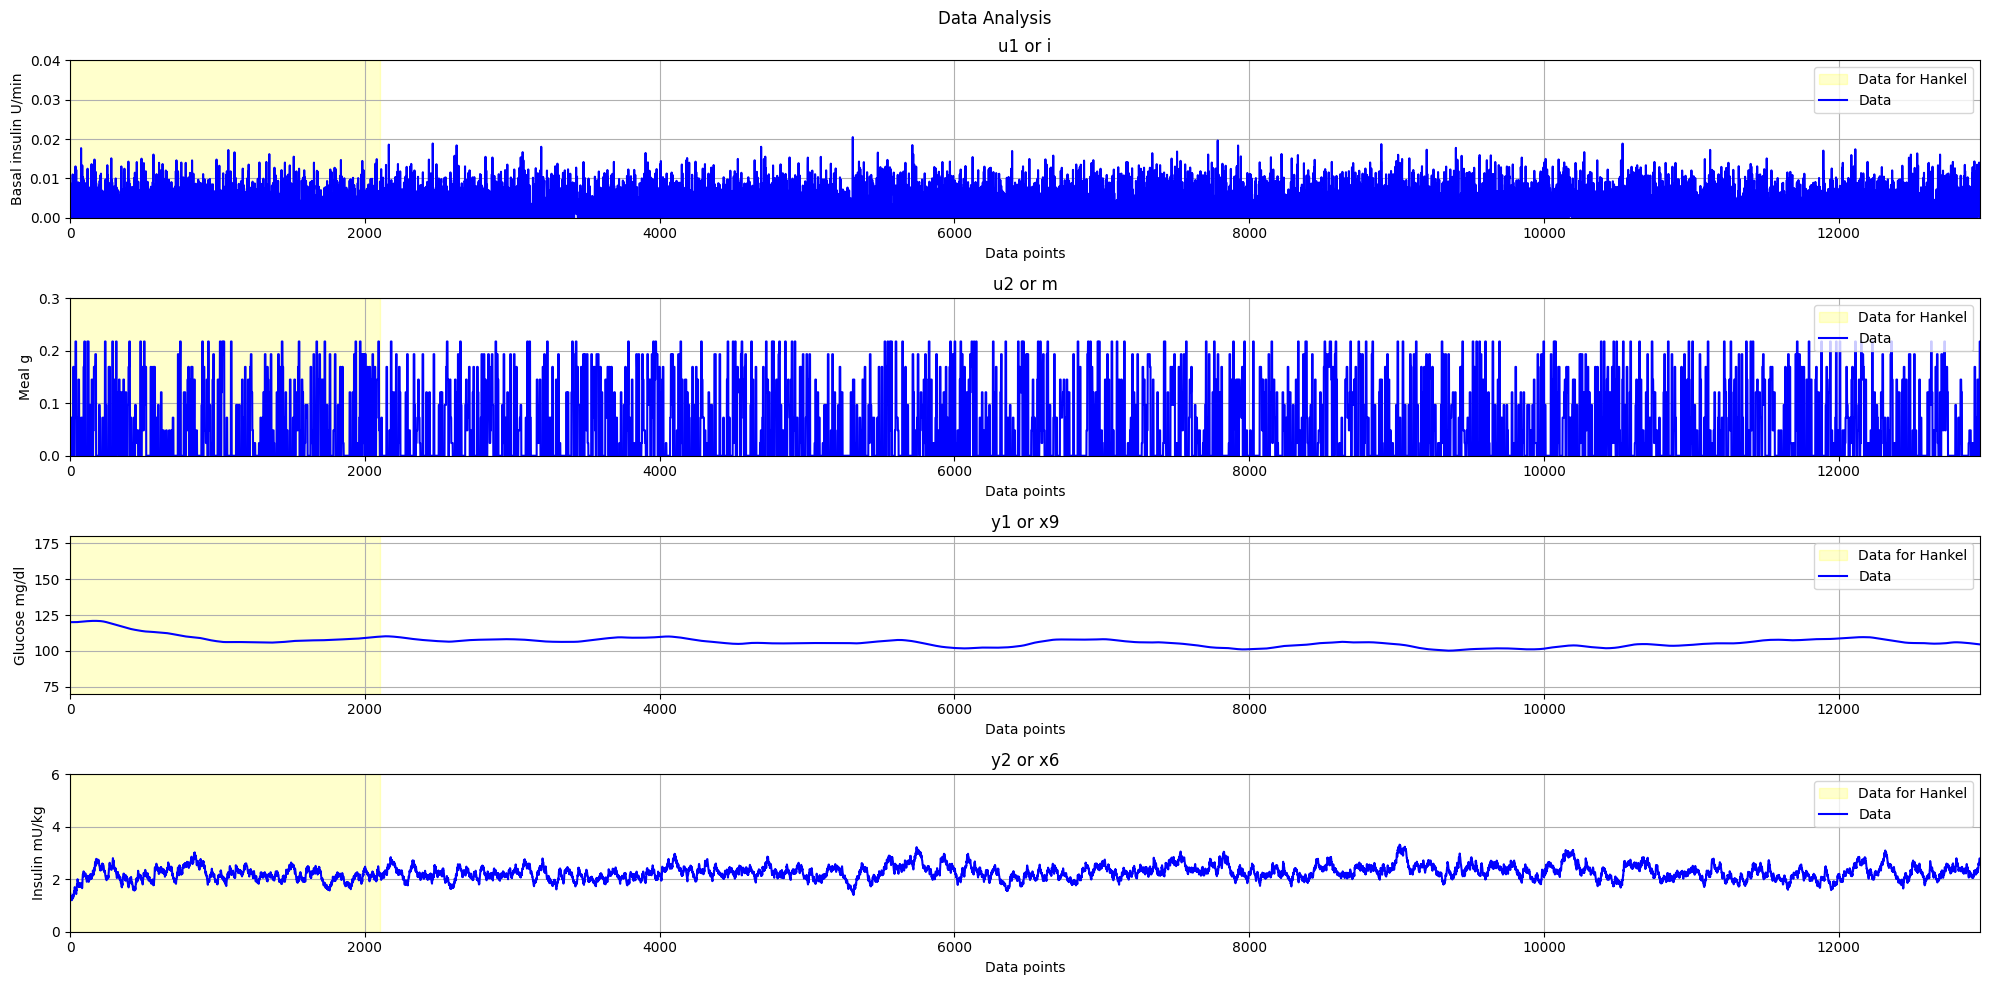

In [34]:
##################################### Data Analysis ###################################
# Variables for the plot
x_label = "Data points"
tot_num_data_used = num_hankel_cols_d * discret_time * multiplicator + L
print(f"Total number of data used: {tot_num_data_used}")

# Titles, y-labels, y-limits and data for each subplot
titles = ['u1 or i', 'u2 or m', 'y1 or x9', 'y2 or x6']
y_labels = ['Basal insulin U/min', 'Meal g', 'Glucose mg/dl', 'Insulin mU/kg']
y_lims = [[0, 0.04], [0, 0.3], [70, 180], [0, 6]]
data_col = ['input', 'meal', 'x_8', 'x_5']

# Plot
fig, axs = plt.subplots(4, 1, figsize=(20, 10))
fig.suptitle('Data Analysis')

for i, ax in enumerate(axs.flat):
    ax.fill_between(np.array([0, tot_num_data_used]), np.array([y_lims[i][0], y_lims[i][0]]), np.array([y_lims[i][1], y_lims[i][1]]), color='yellow', alpha=0.2, label='Data for Hankel')
    ax.plot(data_DeePC[data_col[i]], label='Data', color='blue')
    ax.set_title(titles[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_labels[i])
    ax.grid()
    ax.set_ylim(y_lims[i])
    ax.set_xlim([0, num_data_points])
    ax.legend()

plt.tight_layout()
plt.show()
plt.close()

<div>
    <img src="DeePC.png" width="800"/>
</div>

### Mathematical Description of DeePC
As the DeePC algorithm is suitable for noiseless LTI system, using the data (even noiseless in our case) gathered from a non-linear system will not result in a reliable controller. For this reason, a cost to penalize the norm of $\textbf{g}$ and one to penalize the slack variable $\sigma$ are included.

$$
\begin{array}{rll}
\min_{\textbf{u}, \textbf{y}, \textbf{g}} & \sum_{k=0}^{K-1} \|\textbf{y}_k - \textbf{y}_\mathrm{ref} \|^2_Q + \|\textbf{u}_k - \textbf{u}_\mathrm{ref} \|_R^2 + \lambda_g \| \textbf{g} \|_1 + \lambda_\sigma \| \sigma \|_1 & \\
\text{s.t.} & \begin{bmatrix}
\mathcal{H}_L(\textbf{u}_{\text{data}}) \\
\mathcal{H}_L(\textbf{y}_{\text{data}})
\end{bmatrix} \textbf{g} = \begin{bmatrix}
\textbf{u}_{\text{past}} \\
\textbf{u} \\
\textbf{y}_{\text{past}} + \sigma\\
\textbf{y}
\end{bmatrix}, &\\
& \textbf{u}_{1,k} \geq 0 & \forall k, \\
& \textbf{u}_{1,k} \leq 0.04 & \forall k, \\
& \textbf{y}_{1,k} \geq 70 & \forall k,
\end{array}
$$

where
- the objective function is to minimize the deviations from the steady-state,
- $K \in \mathbb{R}$ is the receding horizon,
- $\textbf{u}_k = \begin{bmatrix}i_k & m_k \end{bmatrix}^T$ from the task description,
- $\textbf{x}_{9,k} = G_{k} \geq 70$ mg/dl represents the hard constraint for the hypoglicemia,
- $Q, S \in \mathbb{R}^{9\times9}$ penalyze the states, and
- $r \in \mathbb{R}$ penalyzes the controllable input $i_k$.

### Implementation Description
In order to minimize the computational effort of running the simulation using MPC, we ensure that the OCP is Disciplined Parametrized Programming (DPP) and also Disciplined Convex Programming (DCP) compliant (https://www.cvxpy.org/tutorial/dpp/index.html). This is achieved by considering the following points:
- the OCP is parametrized and constructed only once,
- the cost function is quadratic and therefore convex, and
- the constraints are linear or follow the rules for DPP.

The OCP becomes


### Design/Tuning Parameters


### Possible Improvements
- 

In [ ]:
class DeePController:
    def __init__(self, T_past:int, T_fut:int, num_hankel_cols_d:int, q1:float, q2:float, r1:float, lambda_g:float, lambda_sigma:float, s_ub:float, s_lb:float, control_horizon:int, discret_time:int, H:tuple, print_output:bool=False, verbose:bool=False) -> None:
        self.num_hankel_cols_d = num_hankel_cols_d
        self.control_horizon = control_horizon
        self.discret_time = discret_time

        self.T_past = T_past
        self.T_past_d = int(self.T_past / self.discret_time)

        self.T_fut = T_fut
        self.T_fut_d = int(self.T_fut / self.discret_time)

        self.L = self.T_past + self.T_fut
        self.L_d = int(self.L / self.discret_time)

        # Weights cost
        self.Q1 = q1 * np.eye(self.T_fut_d)
        self.Q2 = q2 * np.eye(self.T_fut_d)
        self.R1 = r1 * np.eye(self.T_fut_d)
        self.lambda_g = lambda_g
        self.lambda_sigma = lambda_sigma
        self.s_ub = s_ub
        self.s_lb = s_lb

        # Constraints
        self.u1_lb = np.zeros(self.T_fut_d)
        self.u1_ub = np.ones(self.T_fut_d) * 0.04
        self.y1_lb = np.ones(self.T_fut_d) * 70
        self.y1_ub = np.ones(self.T_fut_d) * 180

        # Unpack Hankel matrix
        self.H_u1, self.H_u2, self.H_y1, self.H_y2 = H

        # Full partitioning of Hankel matrix
        self.H_u1_past = self.H_u1[:self.T_past_d, :]
        self.H_u1_fut = self.H_u1[-self.T_fut_d:, :]
        self.H_u2_past = self.H_u2[:self.T_past_d, :]
        self.H_u2_fut = self.H_u2[-self.T_fut_d:, :]
        self.H_y1_past = self.H_y1[:self.T_past_d, :]
        self.H_y1_fut = self.H_y1[-self.T_fut_d:, :]
        self.H_y2_past = self.H_y2[:self.T_past_d, :]
        self.H_y2_fut = self.H_y2[-self.T_fut_d:, :]

        # Initialize past vectors
        self.u1_past = np.zeros(self.T_past)
        self.u2_past = np.zeros(self.T_past)
        self.y1_past = np.zeros(self.T_past)
        self.y2_past = np.zeros(self.T_past)

        self.verbose = verbose
        self.print_output = print_output
        self.num_infeas = 0
        self.num_None_output = 0
        self.tot_T_sim = 0

        self._init_optimization_problem()

        # Variables for plots
        self.y1_ref = None
        self.y2_ref = None
        self.u1_ref = None
        self.x1 = np.array([])
        self.x6 = np.array([])
        self.x9 = np.array([])
        self.tot_cost = np.zeros(1)
        self.y1_var_open_loop = np.zeros(self.T_fut_d)
        self.y2_var_open_loop = np.zeros(self.T_fut_d)
        self.u1_var_open_loop = np.zeros(self.T_fut_d)
        self.g_var_open_loop = np.zeros(self.num_hankel_cols_d)
        self.sigma_y1_var_open_loop = np.zeros(self.T_past_d)
        self.sigma_y2_var_open_loop = np.zeros(self.T_past_d)
        self.sigma_u1_var_open_loop = np.zeros(self.T_past_d)
        self.slack_y1_ub_var_open_loop = np.zeros(self.T_fut_d)
        self.slack_y1_lb_var_open_loop = np.zeros(self.T_fut_d)

    def _init_optimization_problem(self) -> None:
        """
        Initialize the parametrized optimization problem and its components.
        """
        # Define parameters
        self.u1_past_param = cp.Parameter(self.T_past_d)
        self.u2_past_param = cp.Parameter(self.T_past_d)
        self.y1_past_param = cp.Parameter(self.T_past_d)
        self.y2_past_param = cp.Parameter(self.T_past_d)
        self.y1_ref_param = cp.Parameter(self.T_fut_d)
        self.y2_ref_param = cp.Parameter(self.T_fut_d)
        self.u1_ref_param = cp.Parameter(self.T_fut_d)
        self.meal_fut_param = cp.Parameter(self.T_fut_d)

        # Define optimization variables
        self.u1_var = cp.Variable(self.T_fut_d)
        self.y1_var = cp.Variable(self.T_fut_d)
        self.y2_var = cp.Variable(self.T_fut_d)
        self.g_var = cp.Variable(self.num_hankel_cols_d)
        self.sigma_y1_var = cp.Variable(self.T_past_d)
        self.sigma_y2_var = cp.Variable(self.T_past_d)
        self.slack_y1_ub_var = cp.Variable(self.T_fut_d)
        self.slack_y1_lb_var = cp.Variable(self.T_fut_d) # TODO RIMUOVERE E TENERE COME HARD CONSTRAINT

        # Define the cost function
        cost = (
            cp.quad_form(self.y1_var - self.y1_ref_param, self.Q1) + 
            cp.quad_form(self.y2_var - self.y2_ref_param, self.Q2) +
            cp.quad_form(self.u1_var - self.u1_ref_param, self.R1) +
            cp.norm1(self.g_var) * self.lambda_g +
            cp.norm1(self.sigma_y1_var) * self.lambda_sigma +
            cp.norm1(self.sigma_y2_var) * self.lambda_sigma +
            cp.sum(self.slack_y1_ub_var) * self.s_ub +
            cp.sum(self.slack_y1_lb_var) * self.s_lb
            )

        # Define the constraints
        constraints = [
            self.H_u1_past @ self.g_var == self.u1_past_param,
            self.H_u2_past @ self.g_var == self.u2_past_param,
            self.H_u1_fut @ self.g_var == self.u1_var,
            self.H_u2_fut @ self.g_var == self.meal_fut_param,
            self.H_y1_past @ self.g_var == self.y1_past_param + self.sigma_y1_var,
            self.H_y2_past @ self.g_var == self.y2_past_param + self.sigma_y2_var,
            self.H_y1_fut @ self.g_var == self.y1_var,
            self.H_y2_fut @ self.g_var == self.y2_var,
            self.u1_var >= self.u1_lb,
            self.u1_var <= self.u1_ub,
            self.y1_var >= self.y1_lb - self.slack_y1_lb_var,
            self.y1_var <= self.y1_ub + self.slack_y1_ub_var,
            self.slack_y1_lb_var >= 0,
            self.slack_y1_ub_var >= 0,
            ]

        # Define the problem
        self.problem = cp.Problem(cp.Minimize(cost), constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _save_unfeasible_var(self) -> None:
        """
        Save zeros for all.
        """
        self.tot_cost = np.vstack((self.tot_cost, np.zeros(1)))
        self.y1_var_open_loop = np.vstack((self.y1_var_open_loop, np.zeros(self.T_fut_d)))
        self.y2_var_open_loop = np.vstack((self.y2_var_open_loop, np.zeros(self.T_fut_d)))
        self.u1_var_open_loop = np.vstack((self.u1_var_open_loop, np.zeros(self.T_fut_d)))
        self.g_var_open_loop = np.vstack((self.g_var_open_loop, np.zeros(self.num_hankel_cols_d)))
        self.sigma_y1_var_open_loop = np.vstack((self.sigma_y1_var_open_loop, np.zeros(self.T_past_d)))
        self.sigma_y2_var_open_loop = np.vstack((self.sigma_y2_var_open_loop, np.zeros(self.T_past_d)))
        self.slack_y1_ub_var_open_loop = np.vstack((self.slack_y1_ub_var_open_loop, np.zeros(self.T_fut_d)))
        self.slack_y1_lb_var_open_loop = np.vstack((self.slack_y1_lb_var_open_loop, np.zeros(self.T_fut_d)))

    def _save_var(self) -> None:
        """
        Save the optimized variables.
        """
        self.tot_cost = np.vstack((self.tot_cost, self.problem.value))
        self.y1_var_open_loop = np.vstack((self.y1_var_open_loop, self.y1_var.value))
        self.y2_var_open_loop = np.vstack((self.y2_var_open_loop, self.y2_var.value))
        self.u1_var_open_loop = np.vstack((self.u1_var_open_loop, self.u1_var.value))
        self.g_var_open_loop = np.vstack((self.g_var_open_loop, self.g_var.value))
        self.sigma_y1_var_open_loop = np.vstack((self.sigma_y1_var_open_loop, self.sigma_y1_var.value))
        self.sigma_y2_var_open_loop = np.vstack((self.sigma_y2_var_open_loop, self.sigma_y2_var.value))
        self.slack_y1_ub_var_open_loop = np.vstack((self.slack_y1_ub_var_open_loop, self.slack_y1_ub_var.value))
        self.slack_y1_lb_var_open_loop = np.vstack((self.slack_y1_lb_var_open_loop, self.slack_y1_lb_var.value))
    
    def _update_past_inputs(self, control_output:np.ndarray, meal:np.ndarray) -> None:
        """
        Update the past vectors with the computed control output and meal.
        """
        self.u1_past[:-1] = self.u1_past[1:]
        self.u1_past[-1] = control_output

        self.u2_past[:-1] = self.u2_past[1:]
        self.u2_past[-1] = meal[0]

    def _update_past_outputs(self, x0:np.ndarray) -> None:
        """
        Update the past vectors with the new state.
        """
        self.y1_past[:-1] = self.y1_past[1:]
        self.y1_past[-1] = x0[8]

        self.y2_past[:-1] = self.y2_past[1:]
        self.y2_past[-1] = x0[5]

        self.x1 = np.append(self.x1, x0[0])
        self.x6 = np.append(self.x6, x0[5])
        self.x9 = np.append(self.x9, x0[8])

    def compute_DeePC(self, model, x0, tau, time_index, inputs_, xss, uss, dss) -> tuple:
        """
        Implements the tracking MPC controller.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        self.tot_T_sim = time_index

        # Save reference values at the first time step
        if time_index == 0:
            self.y1_ref = np.ones(self.T_fut_d) * xss[8]
            self.y2_ref = np.ones(self.T_fut_d) * xss[5]
            self.u1_ref = np.ones(self.T_fut_d) * uss

            self.y1_ref_param.value = self.y1_ref
            self.y2_ref_param.value = self.y2_ref
            self.u1_ref_param.value = self.u1_ref

            # Set open-loop control
            dss.basal_handler_params['open-loop input'] = np.ones(self.T_fut) * uss

        # Populate past vectors
        if time_index < self.T_past:
            self.y1_past[time_index] = x0[8]
            self.y2_past[time_index] = x0[5]

            control_output = uss
            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            self.u1_past[time_index] = control_output
            self.u2_past[time_index] = meal_next[0]

            self.x1 = np.append(self.x1, x0[0])
            self.x6 = np.append(self.x6, x0[5])
            self.x9 = np.append(self.x9, x0[8])

            if self.print_output:
                print(f"Gathering past data. Fix control output: {control_output}")
            return control_output, dss

        # Optimization right after T_past or at every control horizon
        if (time_index % self.control_horizon) == 0 or time_index == self.T_past:
            self._update_past_outputs(x0)

            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            # Update parameters for DPP
            self.meal_fut_param.value = model.get_discretized_meals(initial_time_step=time_index, duration=self.T_fut, T=self.discret_time)
            self.u1_past_param.value = np.mean(self.u1_past.reshape(-1, self.discret_time), axis=1)
            self.u2_past_param.value = np.sum(self.u2_past.reshape(-1, self.discret_time), axis=1)
            self.y1_past_param.value = np.mean(self.y1_past.reshape(-1, self.discret_time), axis=1)
            self.y2_past_param.value = np.mean(self.y2_past.reshape(-1, self.discret_time), axis=1)

            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.u1_var.value is None:
                    raise Exception("Solver did not find a feasible solution.")
                
            # Fallback solver
            except:       
                try:
                    self.problem.solve(solver=cp.CLARABEL, verbose=self.verbose)

                    # Check if the solution is available
                    if self.u1_var.value is None:
                        self.num_None_output += 1
                        raise Exception("Fallback solver did not find a feasible solution.")

                except:
                    self.num_infeas += 1
                    
                    control_output = dss.basal_handler_params['open-loop input'][time_index % self.control_horizon]

                    self._save_unfeasible_var()

                    self._update_past_inputs(control_output, meal_next)

                    if self.print_output:
                        print(f"Forced control output: {control_output}")
                    return control_output, dss
            
            # Problem solved
            control_output = self.u1_var[0].value
            dss.basal_handler_params['open-loop input'] = np.repeat(self.u1_var.value, self.discret_time)

            self._save_var()
            
            self._update_past_inputs(control_output, meal_next)

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            self._update_past_outputs(x0)

            control_output = dss.basal_handler_params['open-loop input'][time_index % self.control_horizon]
            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            self._update_past_inputs(control_output, meal_next)

            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

------ START ------


c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


------ FINISH ------
Total infeasible solutions: 0.0 %


c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TimeInTarget = 100.0%


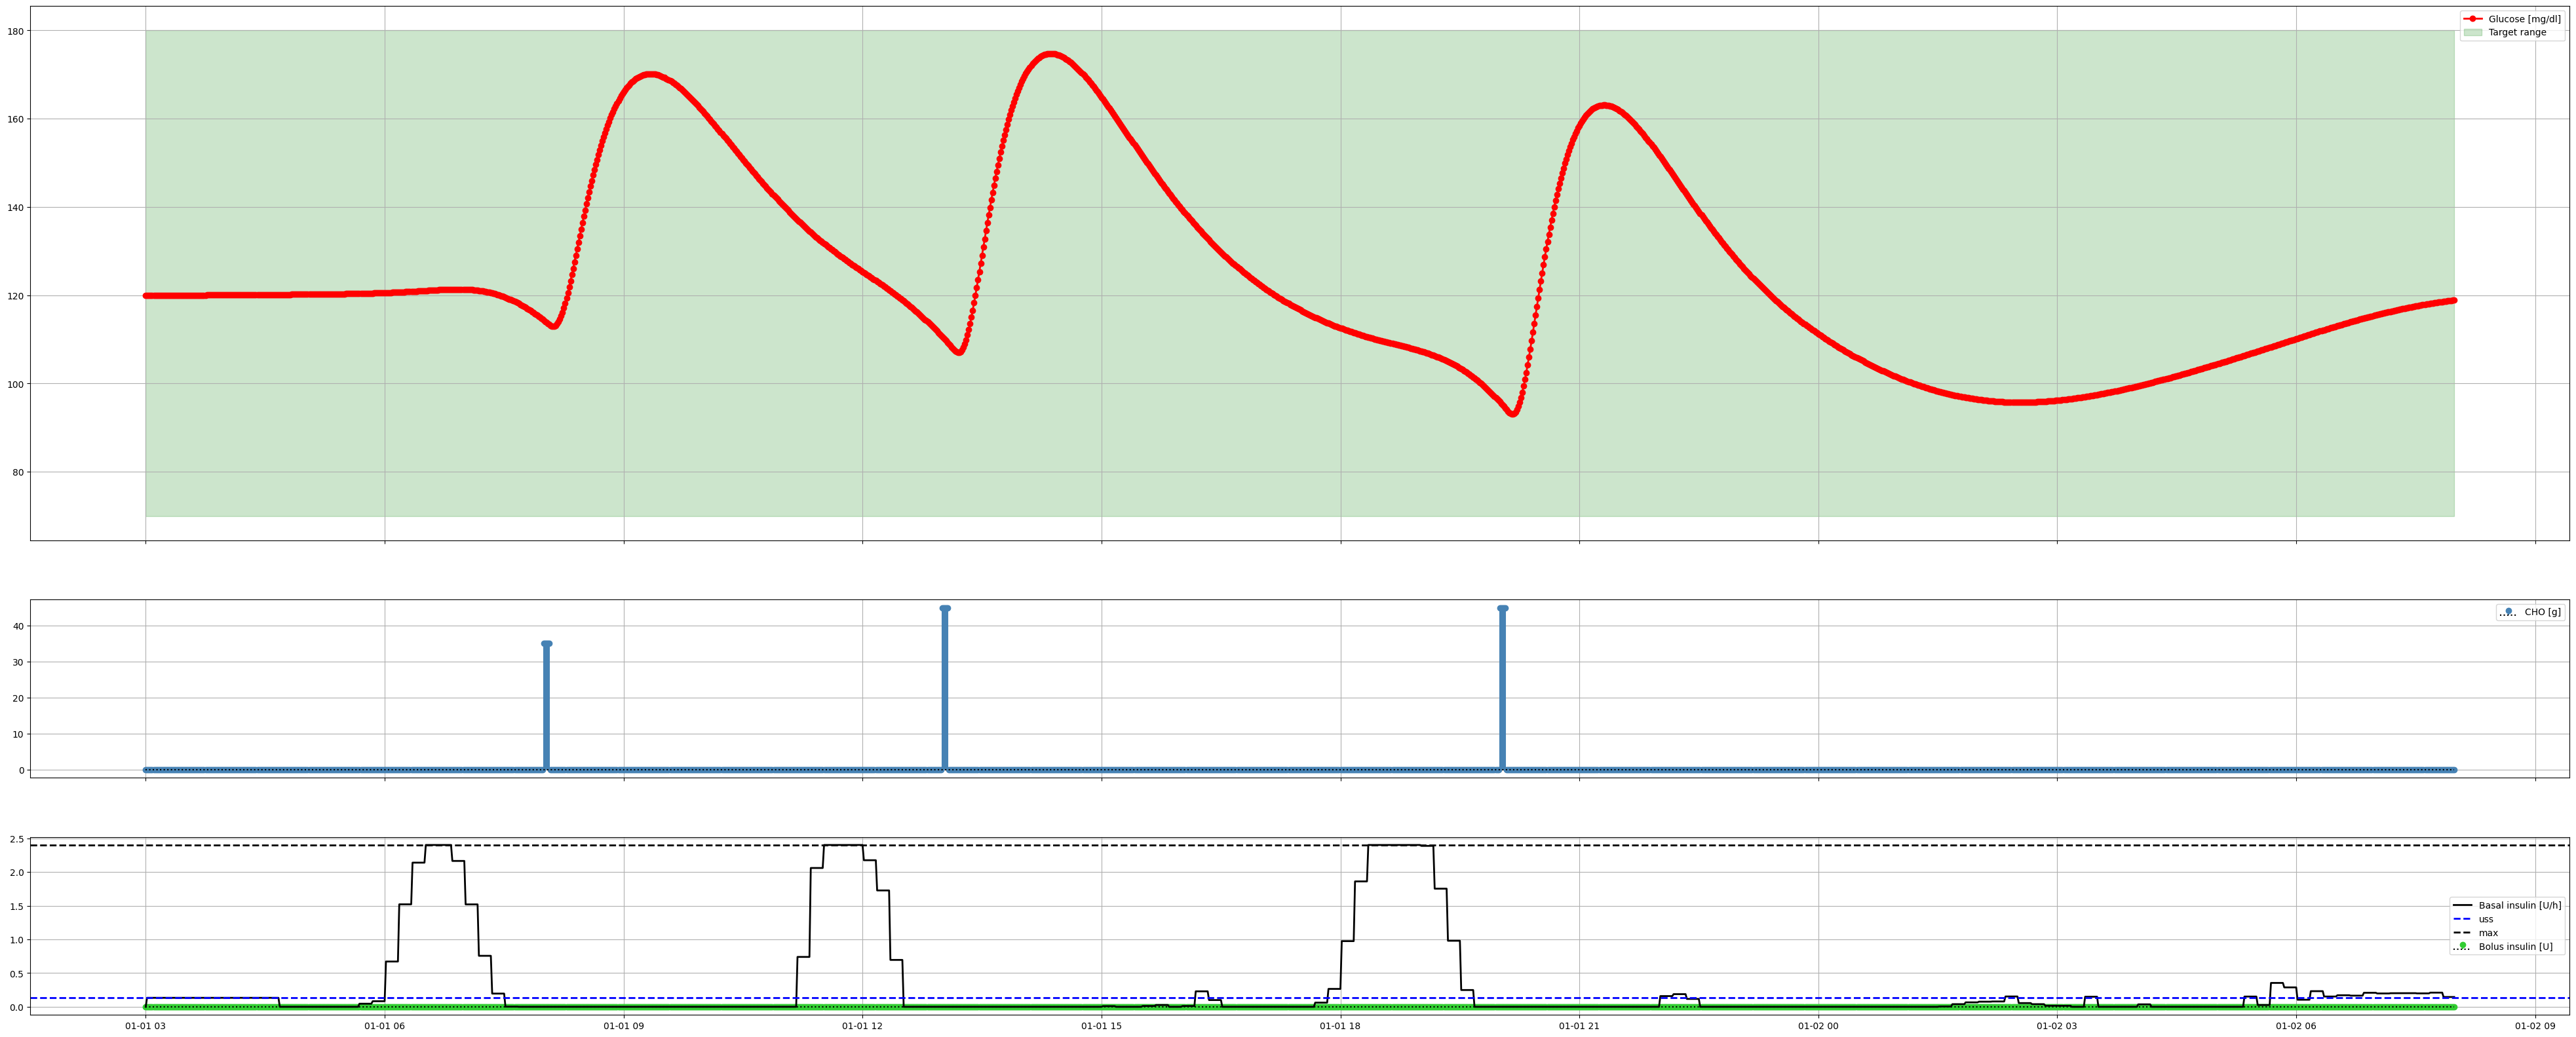

In [35]:
##################################### Run Simulation ###################################
# Initialize the dict to save inputs
basal_handler_params = dict()
basal_handler_params['open-loop input'] = None

# Get the data
# data_given = pd.read_csv('data/zero_test.csv')
# data_given = pd.read_csv('data/basic_test.csv')
# data_given = pd.read_csv('data/easy_test.csv')
# data_given = pd.read_csv('data/data_cho.csv')
data_given = pd.read_csv('data/default_data.csv')

print_output = False

# Instatiating DeePC
controller_DeePC = DeePController(T_past, T_fut, num_hankel_cols_d, q1, q2, r1, lambda_g, lambda_sigma, s_ub, s_lb, control_horizon, discret_time, H, print_output=print_output)

# Running the simulation
print("------ START ------")
glucose, i, insulin_bolus, m, time = simulate(basal_handler=controller_DeePC.compute_DeePC,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)
print("------ FINISH ------")
print("Total infeasible solutions:", np.round((controller_DeePC.num_infeas) / len(controller_DeePC.tot_cost[1:]) * 100, 2), "%")
data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
# print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)

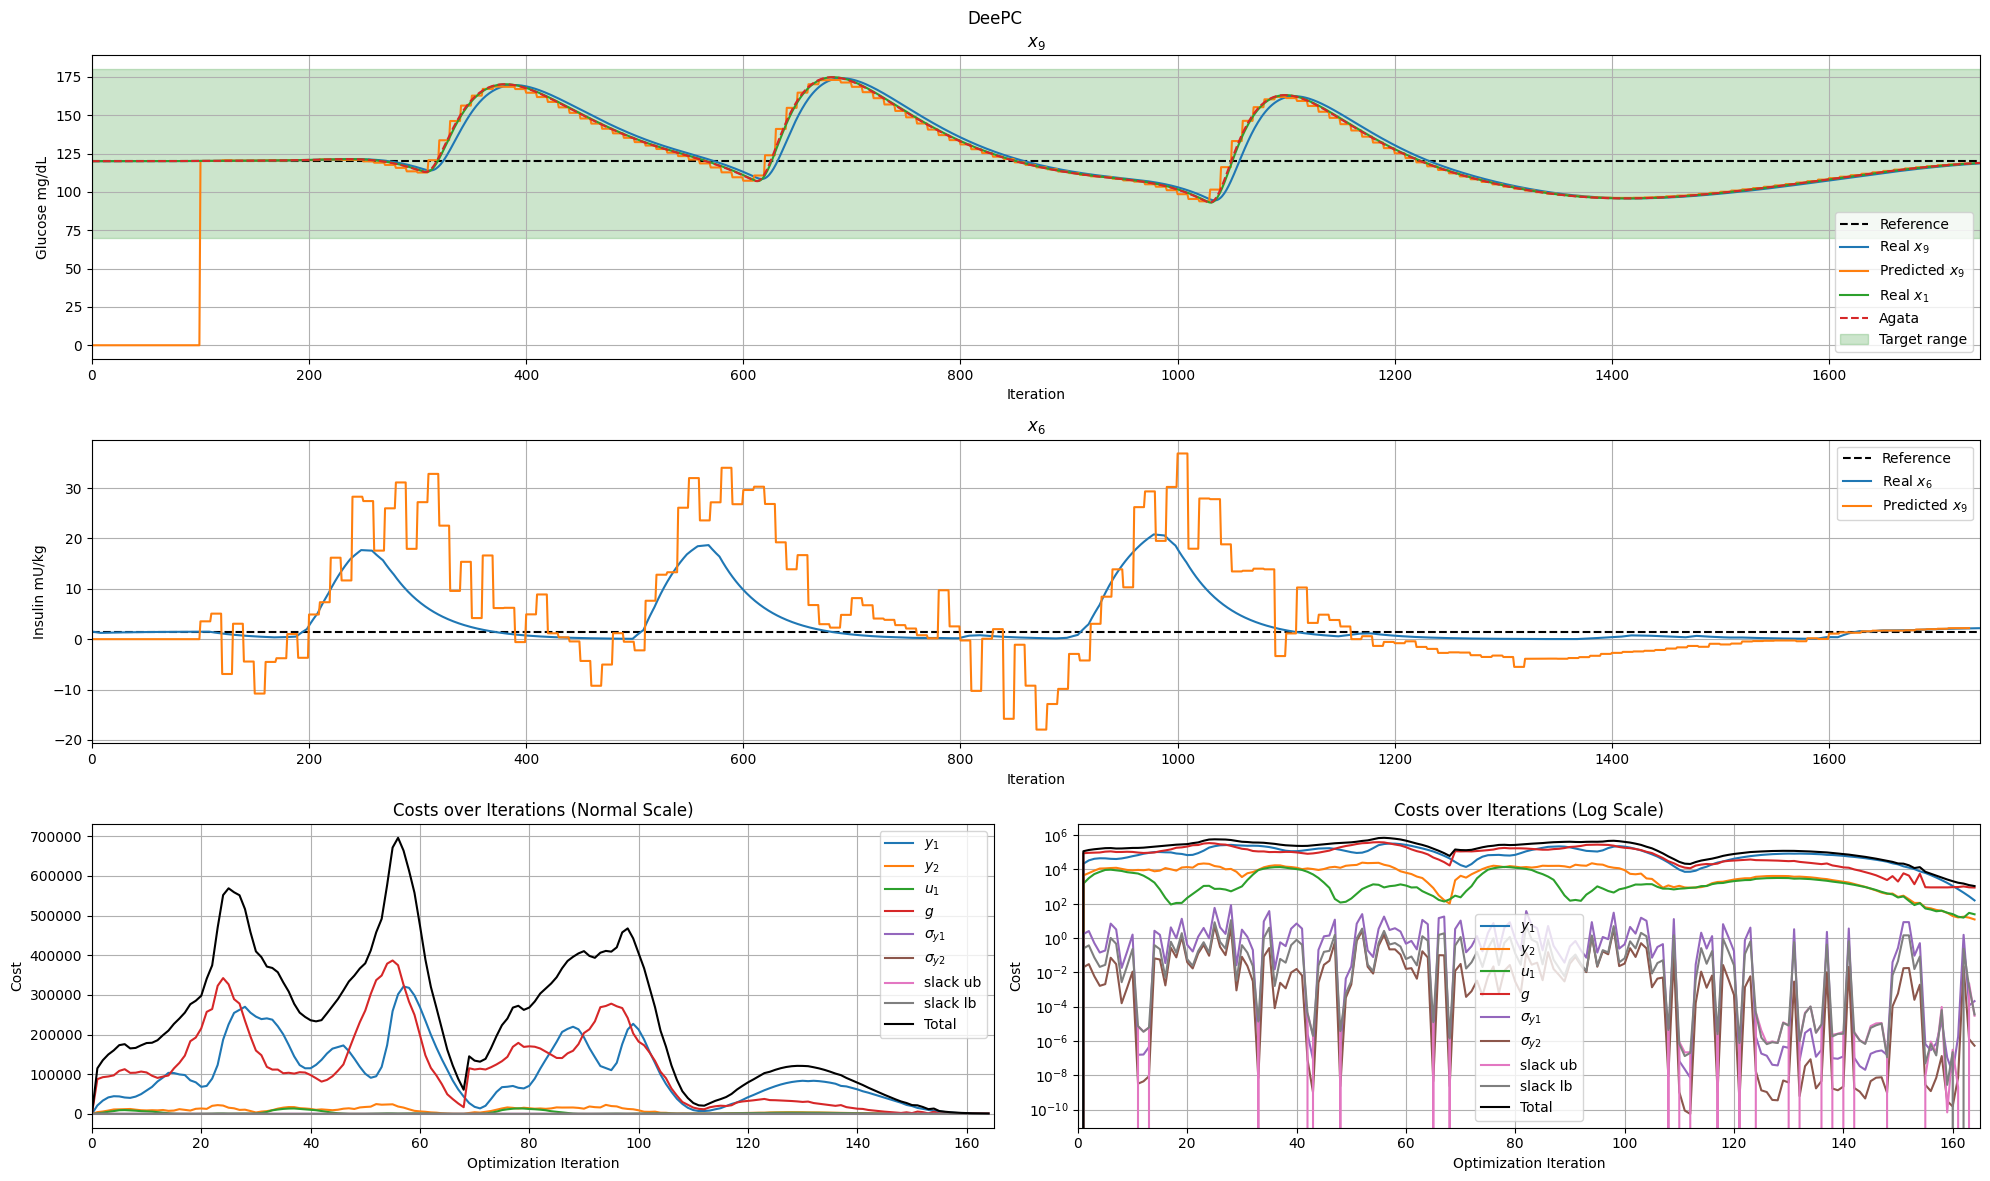

In [36]:
##################################### Post-Processing - Additional Plots ###################################
tot_cost = controller_DeePC.tot_cost
y1_cost = np.zeros(controller_DeePC.y1_var_open_loop.shape[0])
y2_cost = np.zeros(controller_DeePC.y2_var_open_loop.shape[0])
u1_cost = np.zeros(controller_DeePC.u1_var_open_loop.shape[0])
g_cost = np.zeros(controller_DeePC.g_var_open_loop.shape[0])
sigma_y1_cost = np.zeros(controller_DeePC.sigma_y1_var_open_loop.shape[0])
sigma_y2_cost = np.zeros(controller_DeePC.sigma_y2_var_open_loop.shape[0])
slack_y1_ub_cost = np.zeros(controller_DeePC.slack_y1_ub_var_open_loop.shape[0])
slack_y1_lb_cost = np.zeros(controller_DeePC.slack_y1_lb_var_open_loop.shape[0])
g_zero_norm = np.zeros(controller_DeePC.g_var_open_loop.shape[0])

for i in range(1, controller_DeePC.y1_var_open_loop.shape[0]):
    # Set to zero if no cost, meaning no optimization was performed
    if controller_DeePC.tot_cost[i] == 0:
        # Set all costs to zero
        y1_cost[i] = 0
        y2_cost[i] = 0
        u1_cost[i] = 0
        g_cost[i] = 0
        sigma_y1_cost[i] = 0
        sigma_y2_cost[i] = 0
        slack_y1_ub_cost[i] = 0
        slack_y1_lb_cost[i] = 0
        g_zero_norm[i] = 0
    else:
        y1_cost[i] = (controller_DeePC.y1_var_open_loop[i,:] - controller_DeePC.y1_ref).T @ controller_DeePC.Q1 @ (controller_DeePC.y1_var_open_loop[i,:] - controller_DeePC.y1_ref)
        y2_cost[i] = (controller_DeePC.y2_var_open_loop[i,:] - controller_DeePC.y2_ref).T @ controller_DeePC.Q2 @ (controller_DeePC.y2_var_open_loop[i,:] - controller_DeePC.y2_ref)
        u1_cost[i] = (controller_DeePC.u1_var_open_loop[i,:] - controller_DeePC.u1_ref).T @ controller_DeePC.R1 @ (controller_DeePC.u1_var_open_loop[i,:] - controller_DeePC.u1_ref)
        g_cost[i] = np.linalg.norm(controller_DeePC.g_var_open_loop[i,:], 1) * controller_DeePC.lambda_g
        sigma_y1_cost[i] = np.linalg.norm(controller_DeePC.sigma_y1_var_open_loop[i,:], 1) * controller_DeePC.lambda_sigma
        sigma_y2_cost[i] = np.linalg.norm(controller_DeePC.sigma_y2_var_open_loop[i,:], 1) * controller_DeePC.lambda_sigma
        slack_y1_ub_cost[i] = np.sum(controller_DeePC.slack_y1_ub_var_open_loop[i,:]) * controller_DeePC.s_ub
        slack_y1_lb_cost[i] = np.sum(controller_DeePC.slack_y1_lb_var_open_loop[i,:]) * controller_DeePC.s_lb
        g_zero_norm[i] = np.linalg.norm(controller_DeePC.g_var_open_loop[i,:], 0)

# Value used to account for optimization right after T_past
estim_used_first_iter = (T_past // control_horizon + 1) * control_horizon - T_past

y1_open_loop = np.repeat(controller_DeePC.y1_var_open_loop[1:,:], discret_time, axis=1)
y1_estimation = np.append(np.zeros((1, T_past)), y1_open_loop[1,:estim_used_first_iter]) # need to consider the first optimization
y1_estimation = np.append(y1_estimation, y1_open_loop[2:,:control_horizon].reshape(-1,1))

y2_open_loop = np.repeat(controller_DeePC.y2_var_open_loop[1:,:], discret_time, axis=1)
y2_estimation = np.append(np.zeros((1, T_past)), y2_open_loop[1,:estim_used_first_iter]) # need to consider the first optimization
y2_estimation = np.append(y2_estimation, y2_open_loop[2:,:control_horizon].reshape(-1,1))

x_max = len(controller_DeePC.x9)

fig = plt.figure(figsize=(20, 12))
fig.suptitle('DeePC')
gs = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(gs[0, :])
ax1.axhline(y=controller_DeePC.y1_ref[0], color='k', linestyle='--', label='Reference')
ax1.plot(controller_DeePC.x9, label=r'Real $x_9$')
ax1.plot(y1_estimation, label=r'Predicted $x_9$')
ax1.plot(controller_DeePC.x1, label=r'Real $x_1$')
ax1.plot(glucose, linestyle='--', label='Agata')
ax1.fill_between(np.array([0, x_max]), np.array([70, 70]), np.array([180, 180]), color='green', alpha=0.2, label='Target range')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Glucose mg/dL')
ax1.set_title(r'$x_9$')
ax1.legend()
ax1.grid()
ax1.set_xlim(0, x_max)

ax2 = fig.add_subplot(gs[1, :])
ax2.axhline(y=controller_DeePC.y2_ref[0], color='k', linestyle='--', label='Reference')
ax2.plot(controller_DeePC.x6, label=r'Real $x_6$')
ax2.plot(y2_estimation, label=r'Predicted $x_9$')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Insulin mU/kg')
ax2.set_title(r'$x_6$')
ax2.legend()
ax2.grid()
ax2.set_xlim(0, x_max)

# Variables for the loop
plots_info = [
    (fig.add_subplot(gs[2, 0]), 'Costs over Iterations (Normal Scale)', 'linear'),
    (fig.add_subplot(gs[2, 1]), 'Costs over Iterations (Log Scale)', 'log')
    ]
costs_data = [
    (y1_cost, r'$y_1$'),
    (y2_cost, r'$y_2$'),
    (u1_cost, r'$u_1$'),
    (g_cost, r'$g$'),
    (sigma_y1_cost, r'$\sigma_{y1}$'),
    (sigma_y2_cost, r'$\sigma_{y2}$'),
    (slack_y1_ub_cost, 'slack ub'),
    (slack_y1_lb_cost, 'slack lb'),
    (tot_cost, 'Total', 'k')
    ]
# Costs
for ax, title, yscale in plots_info:
    for data, label, *color in costs_data:
        ax.plot(data, label=label, color=color[0] if color else None)
    ax.set_xlabel('Optimization Iteration')
    ax.set_ylabel('Cost')
    ax.set_title(title)
    ax.legend()
    ax.grid()
    ax.set_xlim(0, len(tot_cost))
    ax.set_yscale(yscale)

plt.tight_layout()
plt.show()
plt.close()

## Task 5: Bonus

Use the ReplayBG simulator, or data from the simulator, to either improve upon one of the two AP controllers you proposed in a significant manner, or demonstrate a new controller which requires a simulator or more data.






In [43]:
class DeePController_bonus:
    def __init__(self, T_past:int, T_fut:int, num_hankel_cols_d:int, q1:float, r1:float, lambda_g:float, lambda_sigma:float, s_ub:float, control_horizon:int, discret_time:int, H:tuple, print_output:bool=False, verbose:bool=False) -> None:
        self.num_hankel_cols_d = num_hankel_cols_d
        self.control_horizon = control_horizon
        self.discret_time = discret_time

        self.T_past = T_past
        self.T_past_d = int(self.T_past / self.discret_time)

        self.T_fut = T_fut
        self.T_fut_d = int(self.T_fut / self.discret_time)

        self.L = self.T_past + self.T_fut
        self.L_d = int(self.L / self.discret_time)

        # Weights cost
        self.Q1 = q1 * np.eye(self.T_fut_d)
        self.R1 = r1 * np.eye(self.T_fut_d)
        self.lambda_g = lambda_g
        self.lambda_sigma = lambda_sigma
        self.s_ub = s_ub

        # Constraints
        self.u1_lb = np.zeros(self.T_fut_d)
        self.u1_ub = np.ones(self.T_fut_d) * 0.04
        self.y1_lb = np.ones(self.T_fut_d) * 70
        self.y1_ub = np.ones(self.T_fut_d) * 180

        # Unpack Hankel matrix
        self.H_u1, self.H_u2, self.H_y1 = H

        # Full partitioning of Hankel matrix
        self.H_u1_past = self.H_u1[:self.T_past_d, :]
        self.H_u1_fut = self.H_u1[-self.T_fut_d:, :]
        self.H_u2_past = self.H_u2[:self.T_past_d, :]
        self.H_u2_fut = self.H_u2[-self.T_fut_d:, :]
        self.H_y1_past = self.H_y1[:self.T_past_d, :]
        self.H_y1_fut = self.H_y1[-self.T_fut_d:, :]

        # Initialize past vectors
        self.u1_past = np.zeros(self.T_past)
        self.u2_past = np.zeros(self.T_past)
        self.y1_past = np.zeros(self.T_past)

        self.verbose = verbose
        self.print_output = print_output
        self.num_infeas = 0
        self.num_None_output = 0
        self.tot_T_sim = 0

        self._init_optimization_problem()

        # Variables for plots
        self.y1_ref = None
        self.u1_ref = None
        self.x9 = np.array([])
        self.tot_cost = np.zeros(1)
        self.y1_var_open_loop = np.zeros(self.T_fut_d)
        self.u1_var_open_loop = np.zeros(self.T_fut_d)
        self.g_var_open_loop = np.zeros(self.num_hankel_cols_d)
        self.sigma_y1_var_open_loop = np.zeros(self.T_past_d)
        self.sigma_u1_var_open_loop = np.zeros(self.T_past_d)
        self.slack_y1_ub_var_open_loop = np.zeros(self.T_fut_d)

    def _init_optimization_problem(self) -> None:
        """
        Initialize the parametrized optimization problem and its components.
        """
        # Define parameters
        self.u1_past_param = cp.Parameter(self.T_past_d)
        self.u2_past_param = cp.Parameter(self.T_past_d)
        self.y1_past_param = cp.Parameter(self.T_past_d)
        self.y1_ref_param = cp.Parameter(self.T_fut_d)
        self.u1_ref_param = cp.Parameter(self.T_fut_d)
        self.meal_fut_param = cp.Parameter(self.T_fut_d)

        # Define optimization variables
        self.u1_var = cp.Variable(self.T_fut_d)
        self.y1_var = cp.Variable(self.T_fut_d)
        self.g_var = cp.Variable(self.num_hankel_cols_d)
        self.sigma_y1_var = cp.Variable(self.T_past_d)
        self.slack_y1_ub_var = cp.Variable(self.T_fut_d)

        # Define the cost function
        cost = (
            cp.quad_form(self.y1_var - self.y1_ref_param, self.Q1) +
            cp.quad_form(self.u1_var - self.u1_ref_param, self.R1) +
            cp.norm1(self.g_var) * self.lambda_g +
            cp.norm1(self.sigma_y1_var) * self.lambda_sigma +
            cp.quad_form(self.slack_y1_ub_var, np.eye(T_fut_d)) * self.s_ub
            )

        # Define the constraints
        constraints = [
            self.H_u1_past @ self.g_var == self.u1_past_param,
            self.H_u2_past @ self.g_var == self.u2_past_param,
            self.H_u1_fut @ self.g_var == self.u1_var,
            self.H_u2_fut @ self.g_var == self.meal_fut_param,
            self.H_y1_past @ self.g_var == self.y1_past_param + self.sigma_y1_var,
            self.H_y1_fut @ self.g_var == self.y1_var,
            self.u1_var >= self.u1_lb,
            self.u1_var <= self.u1_ub,
            self.y1_var >= self.y1_lb,
            self.y1_var <= self.y1_ub + self.slack_y1_ub_var,
            self.slack_y1_ub_var >= 0,
            self.y1_var[-1] == self.y1_ref_param[-1], # terminal constraint
            ]

        # Define the problem
        self.problem = cp.Problem(cp.Minimize(cost), constraints)

        if self.print_output:
            print("Is the problem DPP compliant?", self.problem.is_dpp())
            print("Is the problem DCP compliant?", self.problem.is_dcp())

    def _save_unfeasible_var(self) -> None:
        """
        Save zeros for all.
        """
        self.tot_cost = np.vstack((self.tot_cost, np.zeros(1)))
        self.y1_var_open_loop = np.vstack((self.y1_var_open_loop, np.zeros(self.T_fut_d)))
        self.u1_var_open_loop = np.vstack((self.u1_var_open_loop, np.zeros(self.T_fut_d)))
        self.g_var_open_loop = np.vstack((self.g_var_open_loop, np.zeros(self.num_hankel_cols_d)))
        self.sigma_y1_var_open_loop = np.vstack((self.sigma_y1_var_open_loop, np.zeros(self.T_past_d)))
        self.slack_y1_ub_var_open_loop = np.vstack((self.slack_y1_ub_var_open_loop, np.zeros(self.T_fut_d)))

    def _save_var(self) -> None:
        """
        Save the optimized variables.
        """
        self.tot_cost = np.vstack((self.tot_cost, self.problem.value))
        self.y1_var_open_loop = np.vstack((self.y1_var_open_loop, self.y1_var.value))
        self.u1_var_open_loop = np.vstack((self.u1_var_open_loop, self.u1_var.value))
        self.g_var_open_loop = np.vstack((self.g_var_open_loop, self.g_var.value))
        self.sigma_y1_var_open_loop = np.vstack((self.sigma_y1_var_open_loop, self.sigma_y1_var.value))
        self.slack_y1_ub_var_open_loop = np.vstack((self.slack_y1_ub_var_open_loop, self.slack_y1_ub_var.value))
    
    def _update_past_inputs(self, control_output:np.ndarray, meal:np.ndarray) -> None:
        """
        Update the past vectors with the computed control output and meal.
        """
        self.u1_past[:-1] = self.u1_past[1:]
        self.u1_past[-1] = control_output

        self.u2_past[:-1] = self.u2_past[1:]
        self.u2_past[-1] = meal[0]

    def _update_past_outputs(self, x0:np.ndarray) -> None:
        """
        Update the past vectors with the new state.
        """
        self.y1_past[:-1] = self.y1_past[1:]
        self.y1_past[-1] = x0[8]

        self.x9 = np.append(self.x9, x0[8])

    def compute_DeePC(self, model, x0, tau, time_index, inputs_, xss, uss, dss) -> tuple:
        """
        Implements the tracking MPC controller.

        Parameters
        -------
        model: the T1DModel class describing the dynamics, provided by ReplayBG
        x0: the current state
        tau: delay of the system in min
        time_index: shows the current time step
        inputs_: a time series with the basal input that was/will be applied to the system
                (useful for implementing delay)
        xss, uss: the linearization point
        dss: Contains basal_handler_params and servers two functions:
            1) a dict that for the controller hyperparameters.
            2) memory for the next iteration (hence dss also being an output)
        
        Returns
        -------
        i: The basal insulin rate to administer at time[time_index+1].
        dss: [see above]
        """
        if self.print_output:
            print(f"--  Simulation time: {time_index} min  -  Infeasible solutions: {self.num_infeas} of which None output: {self.num_None_output}  --")
        self.tot_T_sim = time_index

        # Save reference values at the first time step
        if time_index == 0:
            self.y1_ref = np.ones(self.T_fut_d) * xss[8]
            self.u1_ref = np.ones(self.T_fut_d) * uss

            self.y1_ref_param.value = self.y1_ref
            self.u1_ref_param.value = self.u1_ref

            # Set open-loop control
            dss.basal_handler_params['open-loop input'] = np.ones(self.T_fut) * uss

        # Populate past vectors
        if time_index < self.T_past:
            self.y1_past[time_index] = x0[8]

            control_output = uss
            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            self.u1_past[time_index] = control_output
            self.u2_past[time_index] = meal_next[0]

            self.x9 = np.append(self.x9, x0[8])

            if self.print_output:
                print(f"Gathering past data. Fix control output: {control_output}")
            return control_output, dss

        # Optimization right after T_past or at every control horizon
        if (time_index % self.control_horizon) == 0 or time_index == self.T_past:
            self._update_past_outputs(x0)

            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            # Update parameters for DPP
            self.meal_fut_param.value = model.get_discretized_meals(initial_time_step=time_index, duration=self.T_fut, T=self.discret_time)
            self.u1_past_param.value = np.mean(self.u1_past.reshape(-1, self.discret_time), axis=1)
            self.u2_past_param.value = np.sum(self.u2_past.reshape(-1, self.discret_time), axis=1)
            self.y1_past_param.value = np.mean(self.y1_past.reshape(-1, self.discret_time), axis=1)

            # Solve the optimization problem
            try:
                self.problem.solve(solver=cp.MOSEK, verbose=self.verbose)

                # Check if the solution is available
                if self.u1_var.value is None:
                    raise Exception("Solver did not find a feasible solution.")
                
            # Fallback solver
            except:       
                try:
                    self.problem.solve(solver=cp.CLARABEL, verbose=self.verbose)

                    # Check if the solution is available
                    if self.u1_var.value is None:
                        self.num_None_output += 1
                        raise Exception("Fallback solver did not find a feasible solution.")

                except:
                    self.num_infeas += 1
                    
                    control_output = dss.basal_handler_params['open-loop input'][time_index % self.control_horizon]

                    self._save_unfeasible_var()

                    self._update_past_inputs(control_output, meal_next)

                    if self.print_output:
                        print(f"Forced control output: {control_output}")
                    return control_output, dss
            
            # Problem solved
            control_output = self.u1_var[0].value
            dss.basal_handler_params['open-loop input'] = np.repeat(self.u1_var.value, self.discret_time)

            self._save_var()
            
            self._update_past_inputs(control_output, meal_next)

            if self.print_output:
                print(f"Optimized control output: {control_output}")
            return control_output, dss
        
        # Open-loop control
        else:
            self._update_past_outputs(x0)

            control_output = dss.basal_handler_params['open-loop input'][time_index % self.control_horizon]
            meal_next = model.get_discretized_meals(initial_time_step=time_index, duration=1, T=1)

            self._update_past_inputs(control_output, meal_next)

            if self.print_output:
                print(f"Open-loop control output: {control_output}")
            return control_output, dss

In [44]:
##################################### DeePC: Data-enabled Predictive Control - Bonus ###################################
# System dimensions
n = 9 # known
m = 2
p = 1

# Trajectory
control_horizon = 10
discret_time = 10
K = 300
T_fut = K
assert K % discret_time == 0, "K should be a multiple of the discretization time."
assert K >= control_horizon, "K should be greater than the control horizon."
T_fut_d = int(T_fut / discret_time)

T_past_d = 10
assert T_past_d % discret_time == 0, "T_past_d should be a multiple of the discretization time."
T_ini = int(T_past_d * discret_time)
T_past = T_ini

L = T_past + T_fut
L_d = T_past_d + T_fut_d

# T = (m + 1) * L + n - 1
# T = (m + 1) * (T_ini + L) + n - 1

# Collect data
data_DeePC = pd.read_pickle("data/DeePC_data.pkl")
num_data_points = data_DeePC.shape[0]

# Compute the sum of 'meal' and mean of 'input', 'x_5', and 'x_8' for each group
data_DeePC['group'] = data_DeePC.index // discret_time
data_d = data_DeePC.groupby('group').agg({
    'meal': 'sum',
    'input': 'mean',
    'x_5': 'mean',
    'x_8': 'mean'
    }).reset_index(drop=True)
data_d.columns = ['meal', 'input', 'x_5', 'x_8']

# Hankel matrices
num_hankel_rows_d = (m + p) * L_d
print("Number of Hankel rows:", num_hankel_rows_d)

ratio_H_u = 2.5 # ratio between width and height of H_u (for square H with ratio 1.5)
num_hankel_cols_d = int(m * L_d * ratio_H_u) # same number of columns for H_u and H_y
# num_hankel_cols = T - L + 1
print("Number of Hankel columns:", num_hankel_cols_d)

H_u1_d = np.zeros((L_d, num_hankel_cols_d))
H_u2_d = np.zeros((L_d, num_hankel_cols_d))
H_y1_d = np.zeros((L_d, num_hankel_cols_d))

# multiplicator = (num_data_points - L) // num_hankel_cols_d # for using the maximum amount of data
# multiplicator = max(1, min(multiplicator, L_d))
multiplicator = 1

# Fill the Hankel matrices
for i in range(num_hankel_cols_d):
    H_u1_d[:, i] = data_d['input'][i * multiplicator:i * multiplicator + L_d].values
    H_u2_d[:, i] = data_d['meal'][i * multiplicator:i * multiplicator + L_d].values
    H_y1_d[:, i] = data_d['x_8'][i * multiplicator:i * multiplicator + L_d].values

H = (H_u1_d, H_u2_d, H_y1_d)

# Tuning parameters
q1 = 2
r1 = 1e6
lambda_g = 10
lambda_sigma = 1e6
s_ub = 1

Number of Hankel rows: 120
Number of Hankel columns: 200


Total number of data used: 2400


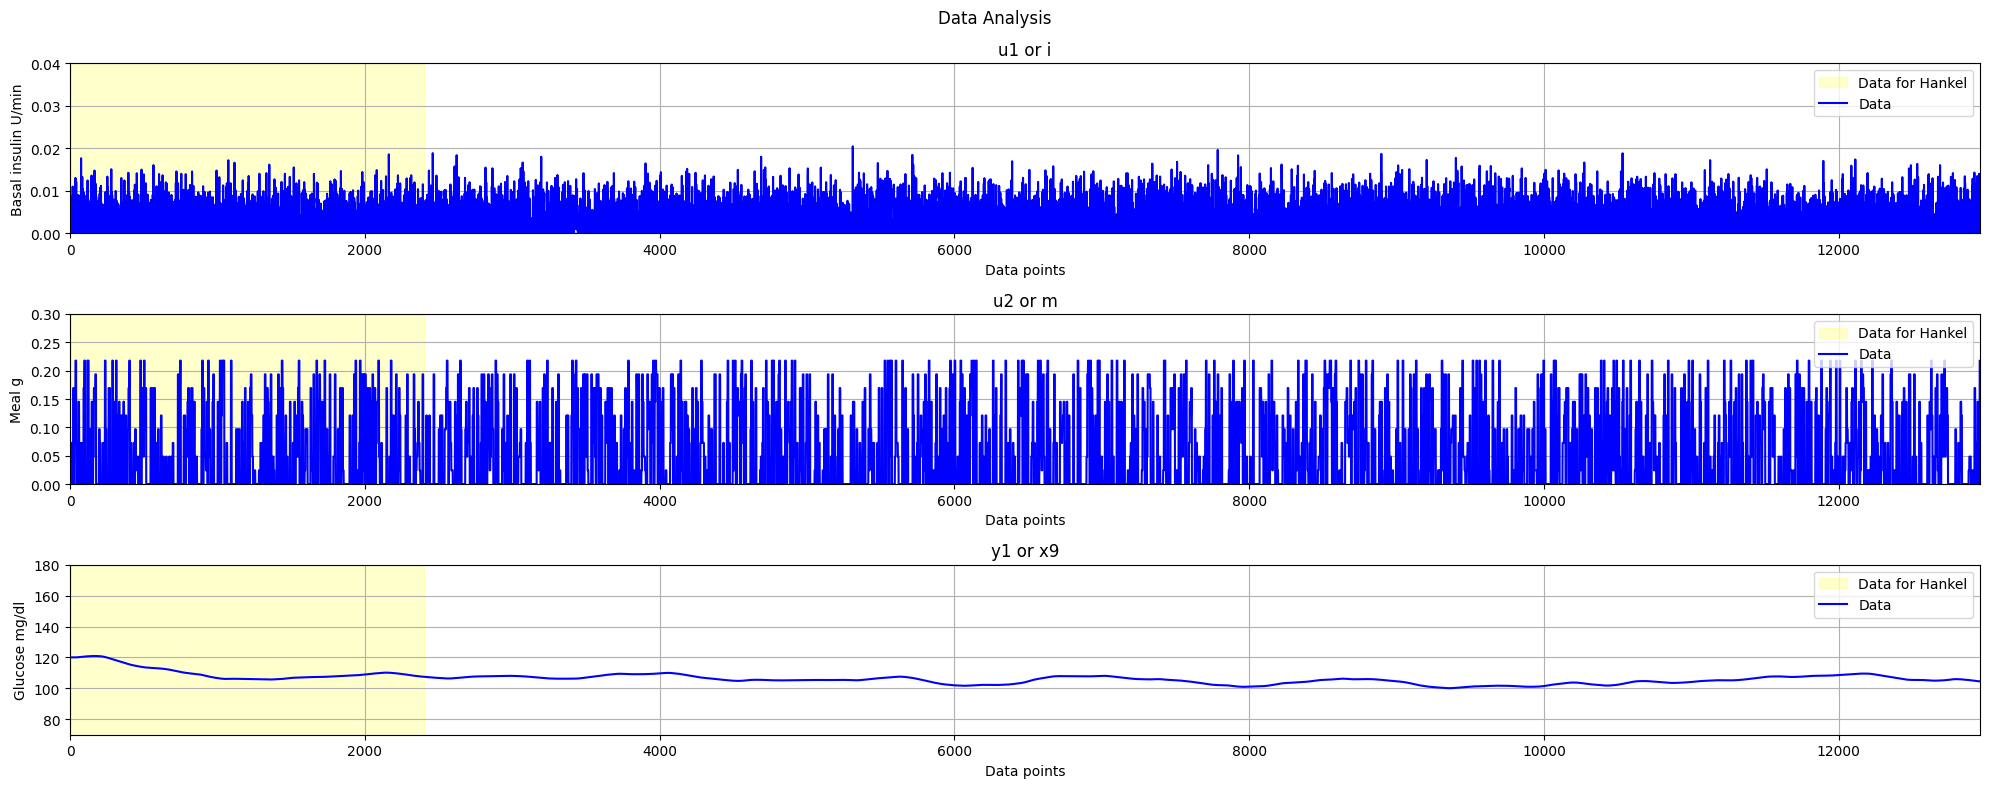

In [45]:
##################################### Data Analysis ###################################
# Variables for the plot
x_label = "Data points"
tot_num_data_used = num_hankel_cols_d * discret_time * multiplicator + L
print(f"Total number of data used: {tot_num_data_used}")

# Titles, y-labels, y-limits and data for each subplot
titles = ['u1 or i', 'u2 or m', 'y1 or x9']
y_labels = ['Basal insulin U/min', 'Meal g', 'Glucose mg/dl']
y_lims = [[0, 0.04], [0, 0.3], [70, 180]]
data_col = ['input', 'meal', 'x_8']

# Plot
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
fig.suptitle('Data Analysis')

for i, ax in enumerate(axs.flat):
    ax.fill_between(np.array([0, tot_num_data_used]), np.array([y_lims[i][0], y_lims[i][0]]), np.array([y_lims[i][1], y_lims[i][1]]), color='yellow', alpha=0.2, label='Data for Hankel')
    ax.plot(data_DeePC[data_col[i]], label='Data', color='blue')
    ax.set_title(titles[i])
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_labels[i])
    ax.grid()
    ax.set_ylim(y_lims[i])
    ax.set_xlim([0, num_data_points])
    ax.legend()

plt.tight_layout()
plt.show()
plt.close()

Is the problem DPP compliant? True
Is the problem DCP compliant? True
------ START ------
--  Simulation time: 0 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 1 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 2 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 3 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 4 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 5 min  -  Infeasible solutions: 0 of which None output: 0  --
Gathering past data. Fix control output: 0.0022258920478113974
--  Simulation time: 6 min  -  Inf

c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\py_agata\variability\__init__.py:729: RuntimeWarning: Mean of empty slice
  mage_day_plus[d] = np.nanmean(excursions[excursions > 0])
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\giaco\Git_Repositories\coco-2024-project\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TimeInTarget = 85.40229885057471%


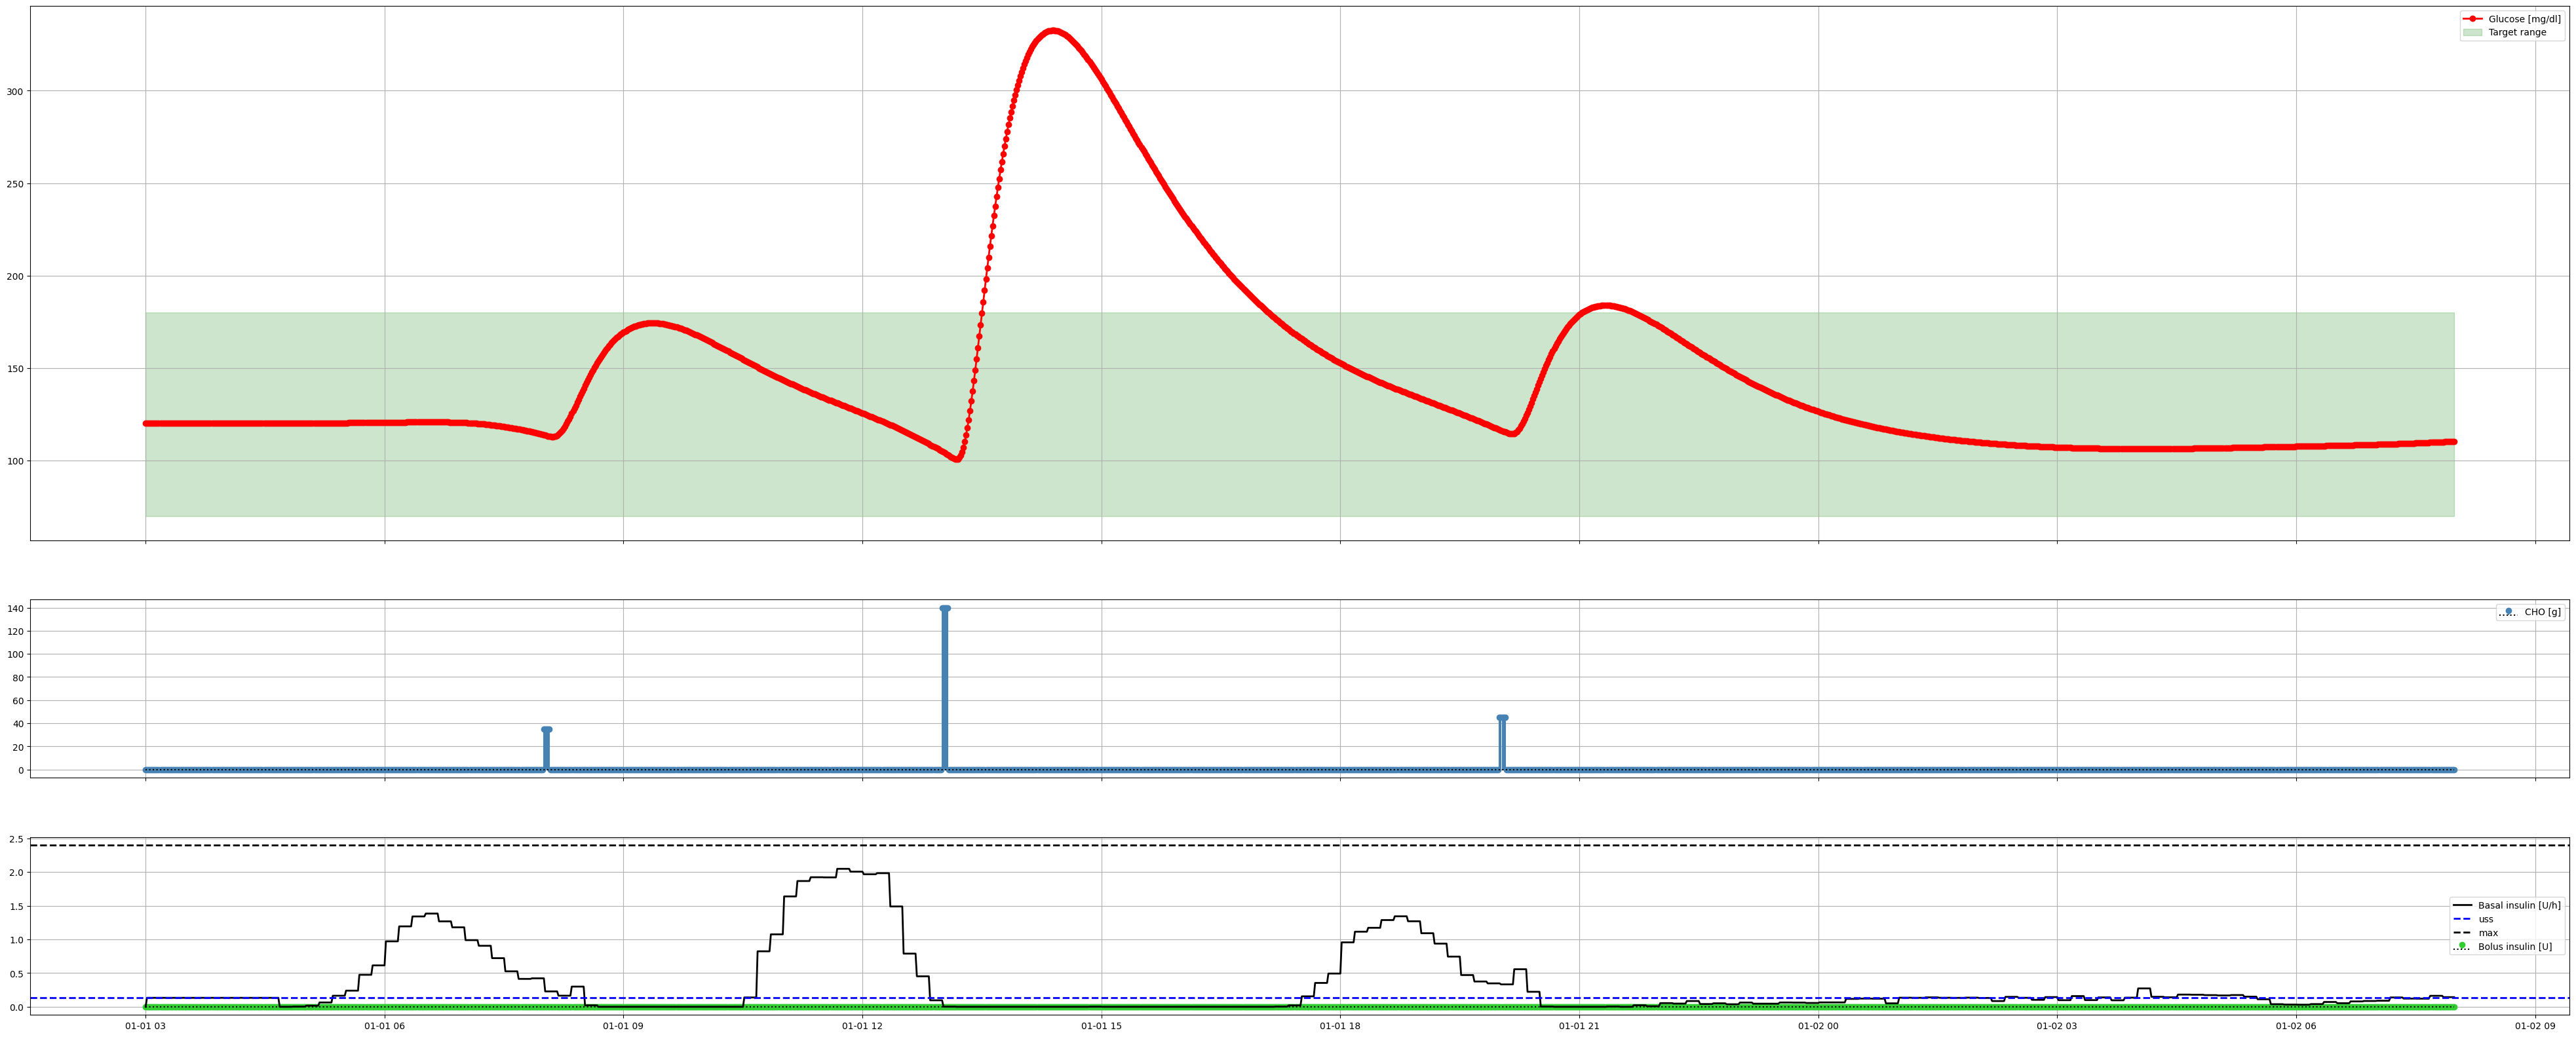

In [46]:
##################################### Run Simulation -  Bonus ###################################
# Initialize the dict to save inputs
basal_handler_params = dict()
basal_handler_params['open-loop input'] = None

# Get the data
# data_given = pd.read_csv('data/max_data.csv')
# data_given = pd.read_csv('data/data_cho.csv')
data_given = pd.read_csv('data/default_data.csv')

print_output = True

# Instatiating DeePC
controller_DeePC = DeePController_bonus(T_past, T_fut, num_hankel_cols_d, q1, r1, lambda_g, lambda_sigma, s_ub, control_horizon, discret_time, H, print_output=print_output)

# Running the simulation
print("------ START ------")
glucose, i, insulin_bolus, m, time = simulate(basal_handler=controller_DeePC.compute_DeePC,
                                              basal_handler_params=basal_handler_params,
                                              data_given=data_given,
                                              meal_input_modulation_factor=1)
print("------ FINISH ------")
print("Total infeasible solutions:", np.round((controller_DeePC.num_infeas) / len(controller_DeePC.tot_cost[1:]) * 100, 2), "%")
data = glucose_time_vectors_to_dataframe(glucose=glucose, t=time)

agata = Agata()
results = agata.analyze_glucose_profile(data)
# print(results)

TimeInTarget = time_in_target(data)
print('TimeInTarget = ' + str(TimeInTarget) + '%')

plot_results(glucose=glucose,insulin_bolus=insulin_bolus, i=i, m=m, time=time)

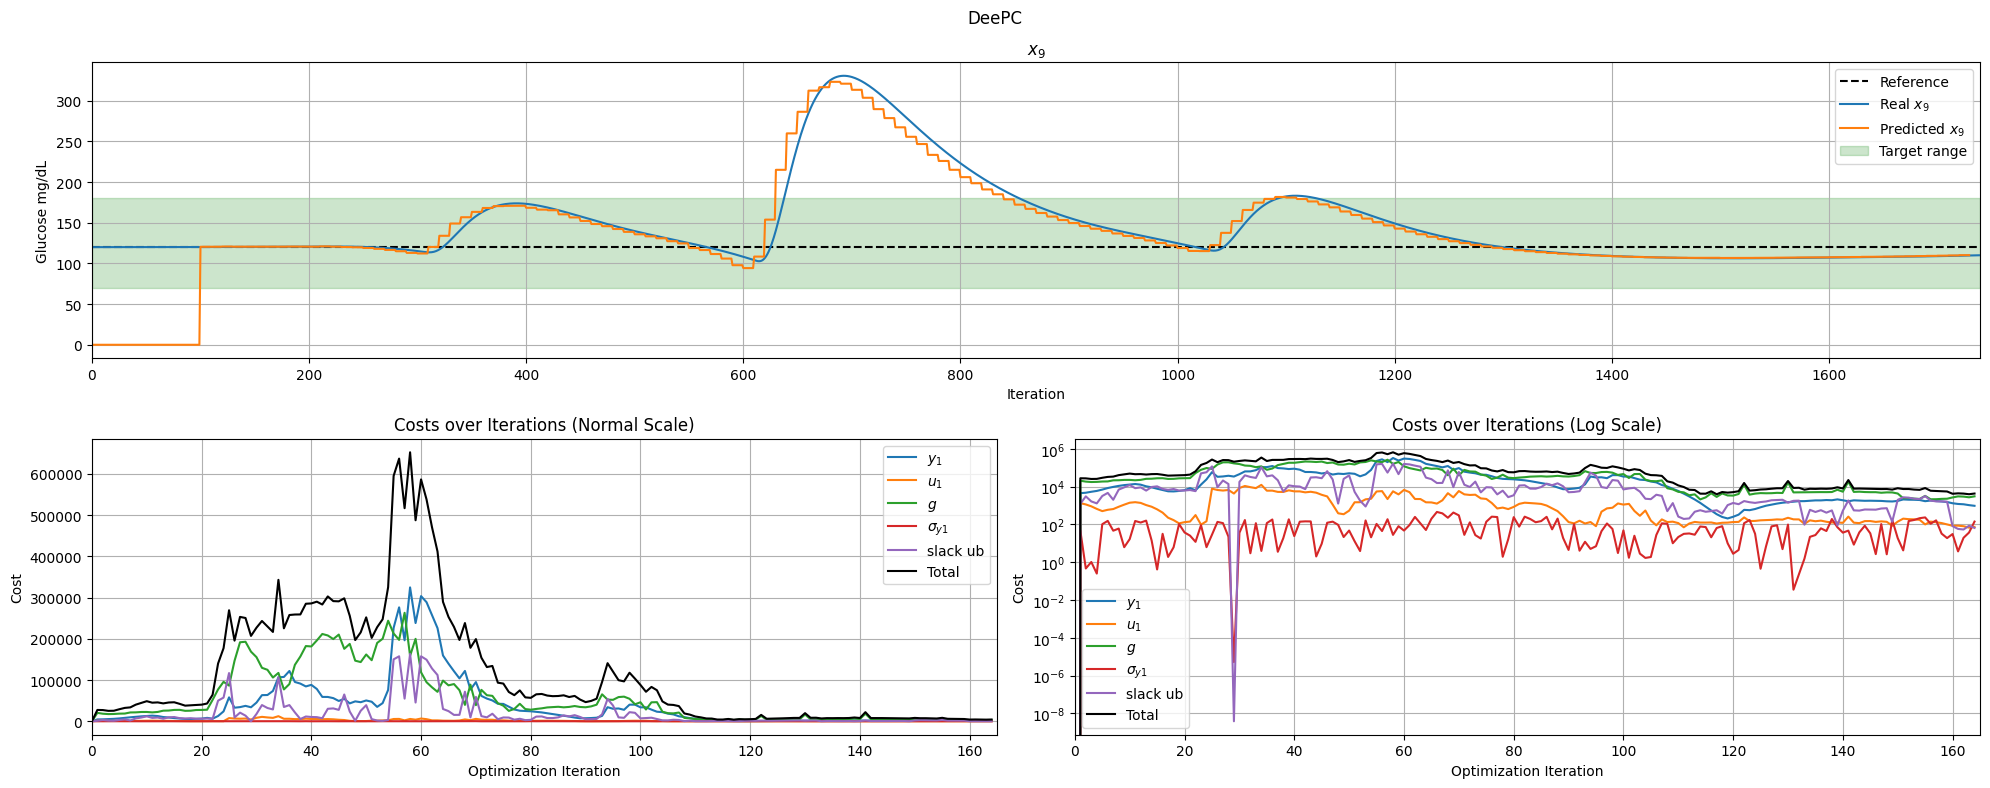

In [47]:
##################################### Post-Processing - Additional Plots - Bonus ###################################
tot_cost = controller_DeePC.tot_cost
y1_cost = np.zeros(controller_DeePC.y1_var_open_loop.shape[0])
u1_cost = np.zeros(controller_DeePC.u1_var_open_loop.shape[0])
g_cost = np.zeros(controller_DeePC.g_var_open_loop.shape[0])
sigma_y1_cost = np.zeros(controller_DeePC.sigma_y1_var_open_loop.shape[0])
slack_y1_ub_cost = np.zeros(controller_DeePC.slack_y1_ub_var_open_loop.shape[0])
g_zero_norm = np.zeros(controller_DeePC.g_var_open_loop.shape[0])

for i in range(1, controller_DeePC.y1_var_open_loop.shape[0]):
    # Set to zero if no cost, meaning no optimization was performed
    if controller_DeePC.tot_cost[i] == 0:
        # Set all costs to zero
        y1_cost[i] = 0
        u1_cost[i] = 0
        g_cost[i] = 0
        sigma_y1_cost[i] = 0
        slack_y1_ub_cost[i] = 0
        slack_y1_lb_cost[i] = 0
        g_zero_norm[i] = 0
    else:
        y1_cost[i] = (controller_DeePC.y1_var_open_loop[i,:] - controller_DeePC.y1_ref).T @ controller_DeePC.Q1 @ (controller_DeePC.y1_var_open_loop[i,:] - controller_DeePC.y1_ref)
        u1_cost[i] = (controller_DeePC.u1_var_open_loop[i,:] - controller_DeePC.u1_ref).T @ controller_DeePC.R1 @ (controller_DeePC.u1_var_open_loop[i,:] - controller_DeePC.u1_ref)
        g_cost[i] = np.linalg.norm(controller_DeePC.g_var_open_loop[i,:], 1) * controller_DeePC.lambda_g
        sigma_y1_cost[i] = np.linalg.norm(controller_DeePC.sigma_y1_var_open_loop[i,:], 1) * controller_DeePC.lambda_sigma
        slack_y1_ub_cost[i] = controller_DeePC.slack_y1_ub_var_open_loop[i,:].T @ controller_DeePC.slack_y1_ub_var_open_loop[i,:] * controller_DeePC.s_ub
        # slack_y1_ub_cost[i] = np.sum(controller_DeePC.slack_y1_ub_var_open_loop[i,:]) * controller_DeePC.s_ub
        # slack_y1_lb_cost[i] = np.sum(controller_DeePC.slack_y1_lb_var_open_loop[i,:]) * controller_DeePC.s_lb
        g_zero_norm[i] = np.linalg.norm(controller_DeePC.g_var_open_loop[i,:], 0)

# Value used to account for optimization right after T_past
estim_used_first_iter = (T_past // control_horizon + 1) * control_horizon - T_past

y1_open_loop = np.repeat(controller_DeePC.y1_var_open_loop[1:,:], discret_time, axis=1)
y1_estimation = np.append(np.zeros((1, T_past)), y1_open_loop[1,:estim_used_first_iter]) # need to consider the first optimization
y1_estimation = np.append(y1_estimation, y1_open_loop[2:,:control_horizon].reshape(-1,1))

x_max = len(controller_DeePC.x9)

fig = plt.figure(figsize=(20, 8))
fig.suptitle('DeePC')
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax1.axhline(y=controller_DeePC.y1_ref[0], color='k', linestyle='--', label='Reference')
ax1.plot(controller_DeePC.x9, label=r'Real $x_9$')
ax1.plot(y1_estimation, label=r'Predicted $x_9$')
ax1.fill_between(np.array([0, x_max]), np.array([70, 70]), np.array([180, 180]), color='green', alpha=0.2, label='Target range')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Glucose mg/dL')
ax1.set_title(r'$x_9$')
ax1.legend()
ax1.grid()
ax1.set_xlim(0, x_max)

# Variables for the loop
plots_info = [
    (fig.add_subplot(gs[1, 0]), 'Costs over Iterations (Normal Scale)', 'linear'),
    (fig.add_subplot(gs[1, 1]), 'Costs over Iterations (Log Scale)', 'log')
    ]
costs_data = [
    (y1_cost, r'$y_1$'),
    (u1_cost, r'$u_1$'),
    (g_cost, r'$g$'),
    (sigma_y1_cost, r'$\sigma_{y1}$'),
    (slack_y1_ub_cost, 'slack ub'),
    (tot_cost, 'Total', 'k')
    ]
# Costs
for ax, title, yscale in plots_info:
    for data, label, *color in costs_data:
        ax.plot(data, label=label, color=color[0] if color else None)
    ax.set_xlabel('Optimization Iteration')
    ax.set_ylabel('Cost')
    ax.set_title(title)
    ax.legend()
    ax.grid()
    ax.set_xlim(0, len(tot_cost))
    ax.set_yscale(yscale)

plt.tight_layout()
plt.show()
plt.close()

## If you want to run your code on a different machine

If you choose to run the code on a different machine (e.g. your own etc.), you can do so by creating your own virtual environment. You may also find it helpful to use Mosek, which will require a [Mosek academic license](https://www.mosek.com/products/academic-licenses/).
In order to activate the environment, before opening the notebook, you need to navigate to the provided directory of the project and then source your environment. The packages are compatible with Pyhton3.11, so you should use this version in your environment. The described process will look like/similar to this:

```terminal
git clone https://gitlab.ethz.ch/project_directory.git

cd ~/ProjectDirectory

python -m venv venv 

source venv/bin/activate

pip install -r requirements.txt

pip install cvxpy

pip install mosek

pip install jupyter lab

jupyter lab
```

<font color='red'>NOTE</font>: To directly create your virtual environment using python3.11, you need to find the location of your python3.11 executable and then run `C:/path/to/your/python3-11-executable/python.exe -m venv venv` for windows or `path/to/python3.11 -m venv venv` for ubuntu.